# Food Framing Analysis Script

## Adapted from Tomas Folke 2016 by Pradyumna Sepulveda, Amy Benson and Benedetto de Martino

# Contents

# Data Preparation
## [Load Data](#LoadData)
## [Calculate GSF](#GSF)
## [Calculate DDT](#DDT)
## [Summary Measures](#summary)
## [Compute z and familiarity variables](#zfam)
## [Median Split](#split)
# Data Analysis
## [Correlation Graphs](#corr)
## [Logistic Plots](#log)
## [Regression Analysis](#reg)

# Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import rpy2
%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [4]:
%%R
# Use in case the libraries are not available in the system
#install.packages("lme4")
#install.packages("car")
#install.packages("ggplot2")
#install.packages("broom")
#install.packages("arm")
#install.packages("ggplot2")


NULL


In [5]:
%%R
library(lme4)
library(car)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)

# Defining Functions

## Taken from Thomas Folke

### Plot distributions

In [6]:
def participant_densities(data, var, xlim=(0,100), rug=True):
    # a counter that tells us where a given participant's data should be plotted
    order = 1

    # a list of all the participants in the dataset
    participants = data.loc[:, 'Part'].unique()

    # defining the figure size
    sns.set_style('white')
    fig = figure(figsize=(15,35))

    for x in participants:
        # defining the sub figures
            sub={}
            sub['%s' % x] = plt.subplot(len(participants)/2, 3, order)
            sns.kdeplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x], shade=True)
            #if rug==True:
            #    sns.rugplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x])
            sub['%s' % x].set_title('participant %s' % x)
            #sub['%s' % x].set_xlim(xlim)
            order += 1

### Split variable into participantwise quantiles

In [7]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues

### Full simple logistic graph

In [8]:
def logisticplot_all (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()


    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()

    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5)


    #Plotting the binned data
    data['DVBin2'] = data.groupby(parvar).apply(parsplit, input=xaxis, quantiles=4).values
    
    # determine the x coordinates
    x_cords= data.groupby('DVBin2')[xaxis].mean()
    
    # determine low y coordinates
    y_cords_low = data.loc[(data[moderator]==0), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine low y standard errors
    test = pd.DataFrame(data.loc[(data[moderator]==0), :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_low_error = test.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    
    # determine high y coordinates
    y_cords_high = data.loc[(data[moderator]==1), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine high y standard errors
    test2 = pd.DataFrame(data.loc[data[moderator]==1, :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_high_error = test2.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    # plot the low points
    plt.scatter(x_cords, y_cords_low, c=modlowcol, marker='D', s=60, zorder=1)
    # plot low error bars
    plt.errorbar(x_cords, y_cords_low, yerr=y_low_error, fmt='o', zorder=3, c=modlowcol)
    
    # plot the high points
    plt.scatter(x_cords, y_cords_high, c=modhighcol, marker='o', s=60, zorder=2)
    # plot high error bars
    plt.errorbar(x_cords, y_cords_high, yerr=y_high_error, fmt='o', zorder=4, c=modhighcol)
    
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=2, prop={'size':20})
    sns.despine()

# Data Preparation
_____________________________________________________________________________________________________________________

<a id='LoadData'></a>
# Loading Pilot Data

### Load eyetracker data reports generated by EyeLink DataViewer.
#### Loading Interest Area (IA) and Saccade (Sacc) reports

In [9]:
pX_IA ="/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Reports/IA_FullReport_v1.txt"
pX_Sacc ="/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Reports/SACC_FullReport_v1.txt"

pX_IAframe = [pd.read_csv(pX_IA, sep="\t")]
pX_Saccframe = [pd.read_csv(pX_Sacc, sep="\t")]
pX_IAdata = pd.concat(pX_IAframe)
pX_SACCdata = pd.concat(pX_Saccframe)

pX_IAdata

DATA_FILE  IA_ID  trial  Triplet_Identity  trial_type  \
0        p1.edf      1      1                14  Experiment   
1        p1.edf      2      1                14  Experiment   
2        p1.edf      3      1                14  Experiment   
3        p1.edf      1      2                44  Experiment   
4        p1.edf      2      2                44  Experiment   
5        p1.edf      3      2                44  Experiment   
6        p1.edf      1      3                51  Experiment   
7        p1.edf      2      3                51  Experiment   
8        p1.edf      3      3                51  Experiment   
9        p1.edf      1      4                12  Experiment   
10       p1.edf      2      4                12  Experiment   
11       p1.edf      3      4                12  Experiment   
12       p1.edf      1      5                 4  Experiment   
13       p1.edf      2      5                 4  Experiment   
14       p1.edf      3      5                 4  Experiment   
15       p1.edf      1      6                39  Experiment   
16       p1.edf      2      6                39  Experiment   
17       p1.edf      3      6                39  Experiment   
18       p1.edf      1      7                59  Experiment   
19       p1.edf      2      7                59  Experiment   
20       p1.edf      3      7                59  Experiment   
21       p1.edf      1      8                16  Experiment   
22       p1.edf      2      8                16  Experiment   
23       p1.edf      3      8                16  Experiment   
24       p1.edf      1      9                 1  Experiment   
25       p1.edf      2      9                 1  Experiment   
26       p1.edf      3      9                 1  Experiment   
27       p1.edf      1     10                48  Experiment   
28       p1.edf      2     10                48  Experiment   
29       p1.edf      3     10                48  Experiment   
...         ...    ...    ...               ...         ...   
16530   p26.edf      1    231                55  Experiment   
16531   p26.edf      2    231                55  Experiment   
16532   p26.edf      3    231                55  Experiment   
16533   p26.edf      1    232                18  Experiment   
16534   p26.edf      2    232                18  Experiment   
16535   p26.edf      3    232                18  Experiment   
16536   p26.edf      1    233                 5  Experiment   
16537   p26.edf      2    233                 5  Experiment   
16538   p26.edf      3    233                 5  Experiment   
16539   p26.edf      1    234                12  Experiment   
16540   p26.edf      2    234                12  Experiment   
16541   p26.edf      3    234                12  Experiment   
16542   p26.edf      1    235                28  Experiment   
16543   p26.edf      2    235                28  Experiment   
16544   p26.edf      3    235                28  Experiment   
16545   p26.edf      1    236                25  Experiment   
16546   p26.edf      2    236                25  Experiment   
16547   p26.edf      3    236                25  Experiment   
16548   p26.edf      1    237                31  Experiment   
16549   p26.edf      2    237                31  Experiment   
16550   p26.edf      3    237                31  Experiment   
16551   p26.edf      1    238                53  Experiment   
16552   p26.edf      2    238                53  Experiment   
16553   p26.edf      3    238                53  Experiment   
16554   p26.edf      1    239                11  Experiment   
16555   p26.edf      2    239                11  Experiment   
16556   p26.edf      3    239                11  Experiment   
16557   p26.edf      1    240                54  Experiment   
16558   p26.edf      2    240                54  Experiment   
16559   p26.edf      3    240                54  Experiment   

                               LL_Item  LL_Value  \
0               116_boots_caramels.png      0.9

In [10]:
pX_SACCdata

DATA_FILE  trial  Triplet_Identity CURRENT_SAC_START_INTEREST_AREA_ID  \
0        p1.edf    145               145                                  .   
1        p1.edf    145               145                                  .   
2        p1.edf    145               145                                  .   
3        p1.edf    145               145                                  .   
4        p1.edf    145               145                                  .   
5        p1.edf    145               145                                  .   
6        p1.edf    145               145                                  .   
7        p1.edf    145               145                                  .   
8        p1.edf    145               145                                  .   
9        p1.edf    145               145                                  .   
10       p1.edf    145               145                                  .   
11       p1.edf    145               145                                  .   
12       p1.edf    145               145                                  .   
13       p1.edf    145               145                                  .   
14       p1.edf    145               145                                  .   
15       p1.edf    145               145                                  .   
16       p1.edf    145               145                                  .   
17       p1.edf    145               145                                  .   
18       p1.edf    145               145                                  .   
19       p1.edf    145               145                                  .   
20       p1.edf    145               145                                  .   
21       p1.edf    145               145                                  .   
22       p1.edf    145               145                                  .   
23       p1.edf    145               145                                  .   
24       p1.edf    145               145                                  .   
25       p1.edf    145               145                                  .   
26       p1.edf    145               145                                  .   
27       p1.edf    145               145                                  .   
28       p1.edf    145               145                                  .   
29       p1.edf    145               145                                  .   
...         ...    ...               ...                                ...   
57341   p26.edf    235                28                                  2   
57342   p26.edf    235                28                                  .   
57343   p26.edf    235                28                                  2   
57344   p26.edf    235                28                                  2   
57345   p26.edf    235                28                                  1   
57346   p26.edf    236                25                                  2   
57347   p26.edf    236                25                                  2   
57348   p26.edf    236                25                                  1   
57349   p26.edf    236                25                                  1   
57350   p26.edf    236                25                                  1   
57351   p26.edf    236                25                                  1   
57352   p26.edf    236                25                                  1   
57353   p26.edf    236                25                                  1   
57354   p26.edf    237                31                                  2   
57355   p26.edf    237                31                                  2   
57356   p26.edf    238                53                                  .   
57357   p26.edf    238                53                                  2   
57358   p26.edf    238                53                                  2   
57359   p26.edf    238                53                

## Number of participants and trials 

In [11]:
participant = pX_IAdata['DATA_FILE'].unique()
participant_names = pX_IAdata['DATA_FILE'].unique()

#Extract just names of participant (for folder name in future steps)
yy=0
for xx in participant_names:
    participant_names[yy]=xx.rstrip(".edf")
    yy+=1
print (participant_names)

trial_n = pX_IAdata['trial'].unique()

print("Number of participants:", len(participant))
print ("Number of trials:", len( trial_n))


['p1' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10' 'p11' 'p12' 'p13' 'p14' 'p15' 'p16'
 'p17' 'p18' 'p19' 'p20' 'p21' 'p22' 'p23' 'p24' 'p25' 'p26']
Number of participants: 23
Number of trials: 240


<a id='GSF'></a>
# Calculate GSF for each participant and trial

In [12]:
i=0
GSF_matrix = []

#Run for each individual participant
for i in range(len(participant)):
    #Extract the number of trials for this participant
    pX_indSubj = pX_SACCdata.loc[(pX_SACCdata['DATA_FILE']==participant[i]) & (pX_SACCdata['trial_type']== 'Experiment')]
    trial_n = pX_indSubj['trial'].unique()
    for  j in range(len(trial_n)):
            # extract saccade data for this participant
            GSF_data=pX_SACCdata.loc[(pX_SACCdata['DATA_FILE']==participant[i]) & (pX_SACCdata['trial']== j+1) & (pX_SACCdata['trial_type']== 'Experiment')]
            
            # considered direct glance transition between IA 1 (left) and IA 2 (right)
            booatstart_p1=GSF_data['CURRENT_SAC_START_INTEREST_AREA_ID'] == '2'
            booatend_p1=GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'] == '1'
            booatstart_p2=GSF_data['CURRENT_SAC_START_INTEREST_AREA_ID'] == '1'
            booatend_p2=GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'] == '2'            
            
            #Count shift only if the saccade goes from one area to the other (right to left or left to right item)
            shifts_p1= booatstart_p1 & booatend_p1
            shifts_p2= booatstart_p2 & booatend_p2

            shifts_total = shifts_p1 | shifts_p2
            #Count the total number of shifts in this trial
            trialGSF = sum(shifts_total*1)
            
            #Extract the region (left or right) for the last fixation
            go_back = 1
            tail_fix = GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'].tail(go_back)
            tail_fix = tail_fix.values[0]
            while ('.'== tail_fix) | ('3'== tail_fix):
                go_back = go_back + 1
                tail_fix = GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'].tail(go_back)
                #Since tail gets the last n subjects we need to just pick the one on top
                tail_fix_aux = tail_fix.values
                tail_fix = tail_fix_aux[0]
            
            #add GSF trial info to a new row if the matrix
            GSF_matrix.append([participant[i], j+1, trialGSF, tail_fix]) #trial number, trial GSF, last_fixation
      

In [13]:
#Visualize GSF_matrix
#GSF_matrix

<a id='DDT'></a>
# Calculate DDT for each participant and trial

In [14]:
# Extract measures of dwell time (DT) per Interest Area (IA) in a particular trial
# IA1: left item ; IA2 : right item ; IA3: condition icon
IA1_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 1) & (pX_IAdata['trial_type']== 'Experiment')]
IA2_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 2) & (pX_IAdata['trial_type']== 'Experiment')]
IA3_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 3) & (pX_IAdata['trial_type']== 'Experiment')]

print ("Information contained in IA report ")
list(IA1_data)

Information contained in IA report 


['DATA_FILE',
 'IA_ID',
 'trial',
 'Triplet_Identity',
 'trial_type',
 'LL_Item',
 'LL_Value',
 'LR_Item',
 'LR_Value',
 'Chosen_Img',
 'CHOICE_KEYPRESS',
 'CHOICE_RT',
 'CONF',
 'CONF_RT',
 'Block_Cond',
 'IA_DWELL_TIME',
 'IA_DWELL_TIME_%',
 'IA_FIXATION_COUNT',
 'IA_FIXATION_%',
 'IA_MAX_FIX_PUPIL_SIZE',
 'IA_AVERAGE_FIX_PUPIL_SIZE',
 'IA_MIN_FIX_PUPIL_SIZE',
 'IA_RUN_COUNT',
 'TRIAL_DWELL_TIME',
 'TRIAL_FIXATION_COUNT']

In [15]:
i=0
DDT_matrix = []

#Extract information for each participant. Behavioural parameters also extracted from this report.
for i in range(len(participant)):
    pX_indSubj = pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial_type']== 'Experiment')]
    trial_n = pX_indSubj['trial'].unique()
    for  j in range(len(trial_n)):
            #Extract DT information for the trial IA1 :left ; IA2 : right
            IA1_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 1) & (pX_IAdata['trial_type']== 'Experiment')]
            IA2_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 2) & (pX_IAdata['trial_type']== 'Experiment')]

            #Save additional behavioural parameters
            trial_PairID = IA1_data['Triplet_Identity'].values[0]
            trial_LL_Item = IA1_data['LL_Item'].values[0]
            trial_LL_Value = IA1_data['LL_Value'].values[0]
            trial_LR_Item = IA1_data['LR_Item'].values[0]
            trial_LR_Value = IA1_data['LR_Value'].values[0]
            if IA1_data['CHOICE_KEYPRESS'].values[0] == 'm':
                trial_ChosenItm = 1  # 1: selected item is Right ; 0: selected item is Left
            else: 
                trial_ChosenItm = 0
            trial_ChoiceRT = IA1_data['CHOICE_RT'].values[0]
            trial_Conf = IA1_data['CONF'].values[0]
            trial_ConfRT = IA1_data['CONF_RT'].values[0]
            trial_BlockCond = IA1_data['Block_Cond'].values[0] #1:like 2: dislike
            
            #Calculate DDT values for the trial
            IA_1_DT = IA1_data['IA_DWELL_TIME'].values[0]
            IA_2_DT = IA2_data['IA_DWELL_TIME'].values[0]
            trialDDT = -IA_1_DT + IA_2_DT # since DDT_GSF_Zvalue_trial_part_v2.csv we use RIGHT - LEFT
            
            #define matrix DDT + behavioural parameters
            #DDT_matrix.append([participant[i], j+1, trial_PairID, trial_LL_Item, trial_LL_Value, trial_LR_Item, trial_LR_Value, trial_ChosenItm, trial_ChoiceRT, trial_Conf, trial_ConfRT, trial_BlockCond, trialDDT,IA_1_DT, IA_2_DT]) 
            DDT_matrix.append([i+1, j+1, trial_PairID, trial_LL_Item, trial_LL_Value, trial_LR_Item, trial_LR_Value, trial_ChosenItm, trial_ChoiceRT, trial_Conf, trial_ConfRT, trial_BlockCond, trialDDT,IA_1_DT, IA_2_DT]) 

#list(DDT_matrix)

In [16]:
#Stack both result (GSF and DDT) matrices together
DDT_GSF_trial = np.column_stack((DDT_matrix,GSF_matrix))
DDT_GSF_trial

array([['1', '1', '14', ..., '1', '3', '1'],
       ['1', '2', '44', ..., '2', '3', '2'],
       ['1', '3', '51', ..., '3', '1', '2'],
       ...,
       ['23', '238', '53', ..., '238', '1', '1'],
       ['23', '239', '11', ..., '239', '2', '2'],
       ['23', '240', '54', ..., '240', '1', '1']], dtype='<U36')

In [17]:
#Delete redundant columns(from GSF)
DDT_GSF_trial = np.delete(DDT_GSF_trial, 15, 1) # remove subject_name redundant columns
DDT_GSF_trial = np.delete(DDT_GSF_trial, 15, 1) # remove trial_num redudant column
DDT_GSF_trial

array([['1', '1', '14', ..., '1186', '3', '1'],
       ['1', '2', '44', ..., '1770', '3', '2'],
       ['1', '3', '51', ..., '2091', '1', '2'],
       ...,
       ['23', '238', '53', ..., '1286', '1', '1'],
       ['23', '239', '11', ..., '1769', '2', '2'],
       ['23', '240', '54', ..., '1511', '1', '1']], dtype='<U36')

In [18]:
#Insert headers
DDT_GSF_head = np.insert(DDT_GSF_trial,  0, np.array(('Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat')), axis=0)
DDT_GSF_head

array([['Part', 'TrialN', 'PairID', ..., 'R_IA_DT', 'tGSF', 'lastFixat'],
       ['1', '1', '14', ..., '1186', '3', '1'],
       ['1', '2', '44', ..., '1770', '3', '2'],
       ...,
       ['23', '238', '53', ..., '1286', '1', '1'],
       ['23', '239', '11', ..., '1769', '2', '2'],
       ['23', '240', '54', ..., '1511', '1', '1']], dtype='<U36')

<a id='summary'></a>
# Display Summary Measures

In [19]:
#Generate DataFrame for new summary table 
DataFrameSum1=pd.DataFrame(DDT_GSF_head,columns=['Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat'])
DataFrameSum1=DataFrameSum1.drop(DataFrameSum1.index[0])
DataFrameSum1

Part TrialN PairID                                L_Item L_Value  \
1       1      1     14                116_boots_caramels.png    0.95   
2       1      2     44          102_propercorn_worcester.png     2.3   
3       1      3     51                       59_crunchie.png     1.7   
4       1      4     12               64_nestle_aero_mint.png    1.55   
5       1      5      4           44_walkers_french_fries.png     2.0   
6       1      6     39       50_nakd_rhubarb_and_custard.png    0.65   
7       1      7     59           54_milkyway_magic_stars.png    1.55   
8       1      8     16                116_boots_caramels.png    0.95   
9       1      9      1                  62_cadbury_wispa.png    1.55   
10      1     10     48           44_walkers_french_fries.png     2.0   
11      1     11     37                13_fruit_pastilles.png     1.1   
12      1     12      6     36_nature_valley_protein_bars.png     1.4   
13      1     13     35         41_jelly_babies_berry_mix.png    1.85   
14      1     14     45                       51_smarties.png     1.7   
15      1     15     58                       5_caramello.png    1.25   
16      1     16     41                   11_lindt_orange.png     2.0   
17      1     17     42                         63_kitkat.png    1.85   
18      1     18     52       42_dairy_milk_fruit_and_nut.png    1.55   
19      1     19     49            52_discos_salt_vinegar.png     1.7   
20      1     20     33                         26_yorkie.png     1.7   
21      1     21      7             30_starburst_original.png     1.1   
22      1     22     38                   56_marshmallows.png    0.95   
23      1     23     47                       51_smarties.png     1.7   
24      1     24     34                     19_pistachios.png     1.7   
25      1     25     15  57_food_doctor_mild_korma_crisps.png    1.25   
26      1     26      5                113_walkers_cheese.png     2.0   
27      1     27     46            112_lindt_extra_creamy.png    1.85   
28      1     28     50                         63_kitkat.png    1.85   
29      1     29     43                    103_nakd_berry.png    1.85   
30      1     30     11                     18_galaxy_bar.png     1.1   
...   ...    ...    ...                                   ...     ...   
5491   23    211     32                           24_twix.png    0.95   
5492   23    212      1                     31_beef_jerky.png     1.4   
5493   23    213     24                   56_marshmallows.png     1.4   
5494   23    214      8                 23_kp_grazing_mix.png    1.55   
5495   23    215     29     55_bassetts_licorice_allsorts.png    0.65   
5496   23    216     22                   11_lindt_orange.png     2.0   
5497   23    217      9     53_eat_natural_almond_apricot.png     1.1   
5498   23    218     17             115_shapers_blueberry.png    0.95   
5499   23    219     56            52_discos_salt_vinegar.png    0.95   
5500   23    220     27     36_nature_valley_protein_bars.png    0.65   
5501   23    221     34                113_walkers_cheese.png    0.95   
5502   23    222      4                    110_bombay_mix.png     1.1   
5503   23    223     33  57_food_doctor_mild_korma_crisps.png    0.95   
5504   23    224     60        111_propercorn_sweetnsalty.png    0.95   
5505   23    225     58     36_nature_valley_protein_bars.png    0.65   
5506   23    226     57            60_caramel_rice_crisps.png    0.95   
5507   23    227     21                      109_kp_roast.png    1.55   
5508   23    228     19                       59_crunchie.png    0.95   
5509   23    229     30                    48_mentos_mint.png    0.95   
5510   23    230     23       50_nakd_rhubarb_and_custard.png     1.1   
5511   23    231     55                       51_smarties.png    1.25   
5512   23    232     18            10_hula_hoops_bbq_beef.png    0.95   
5513   23    233      5             30_starburst_original.png  

## Confidence distributions

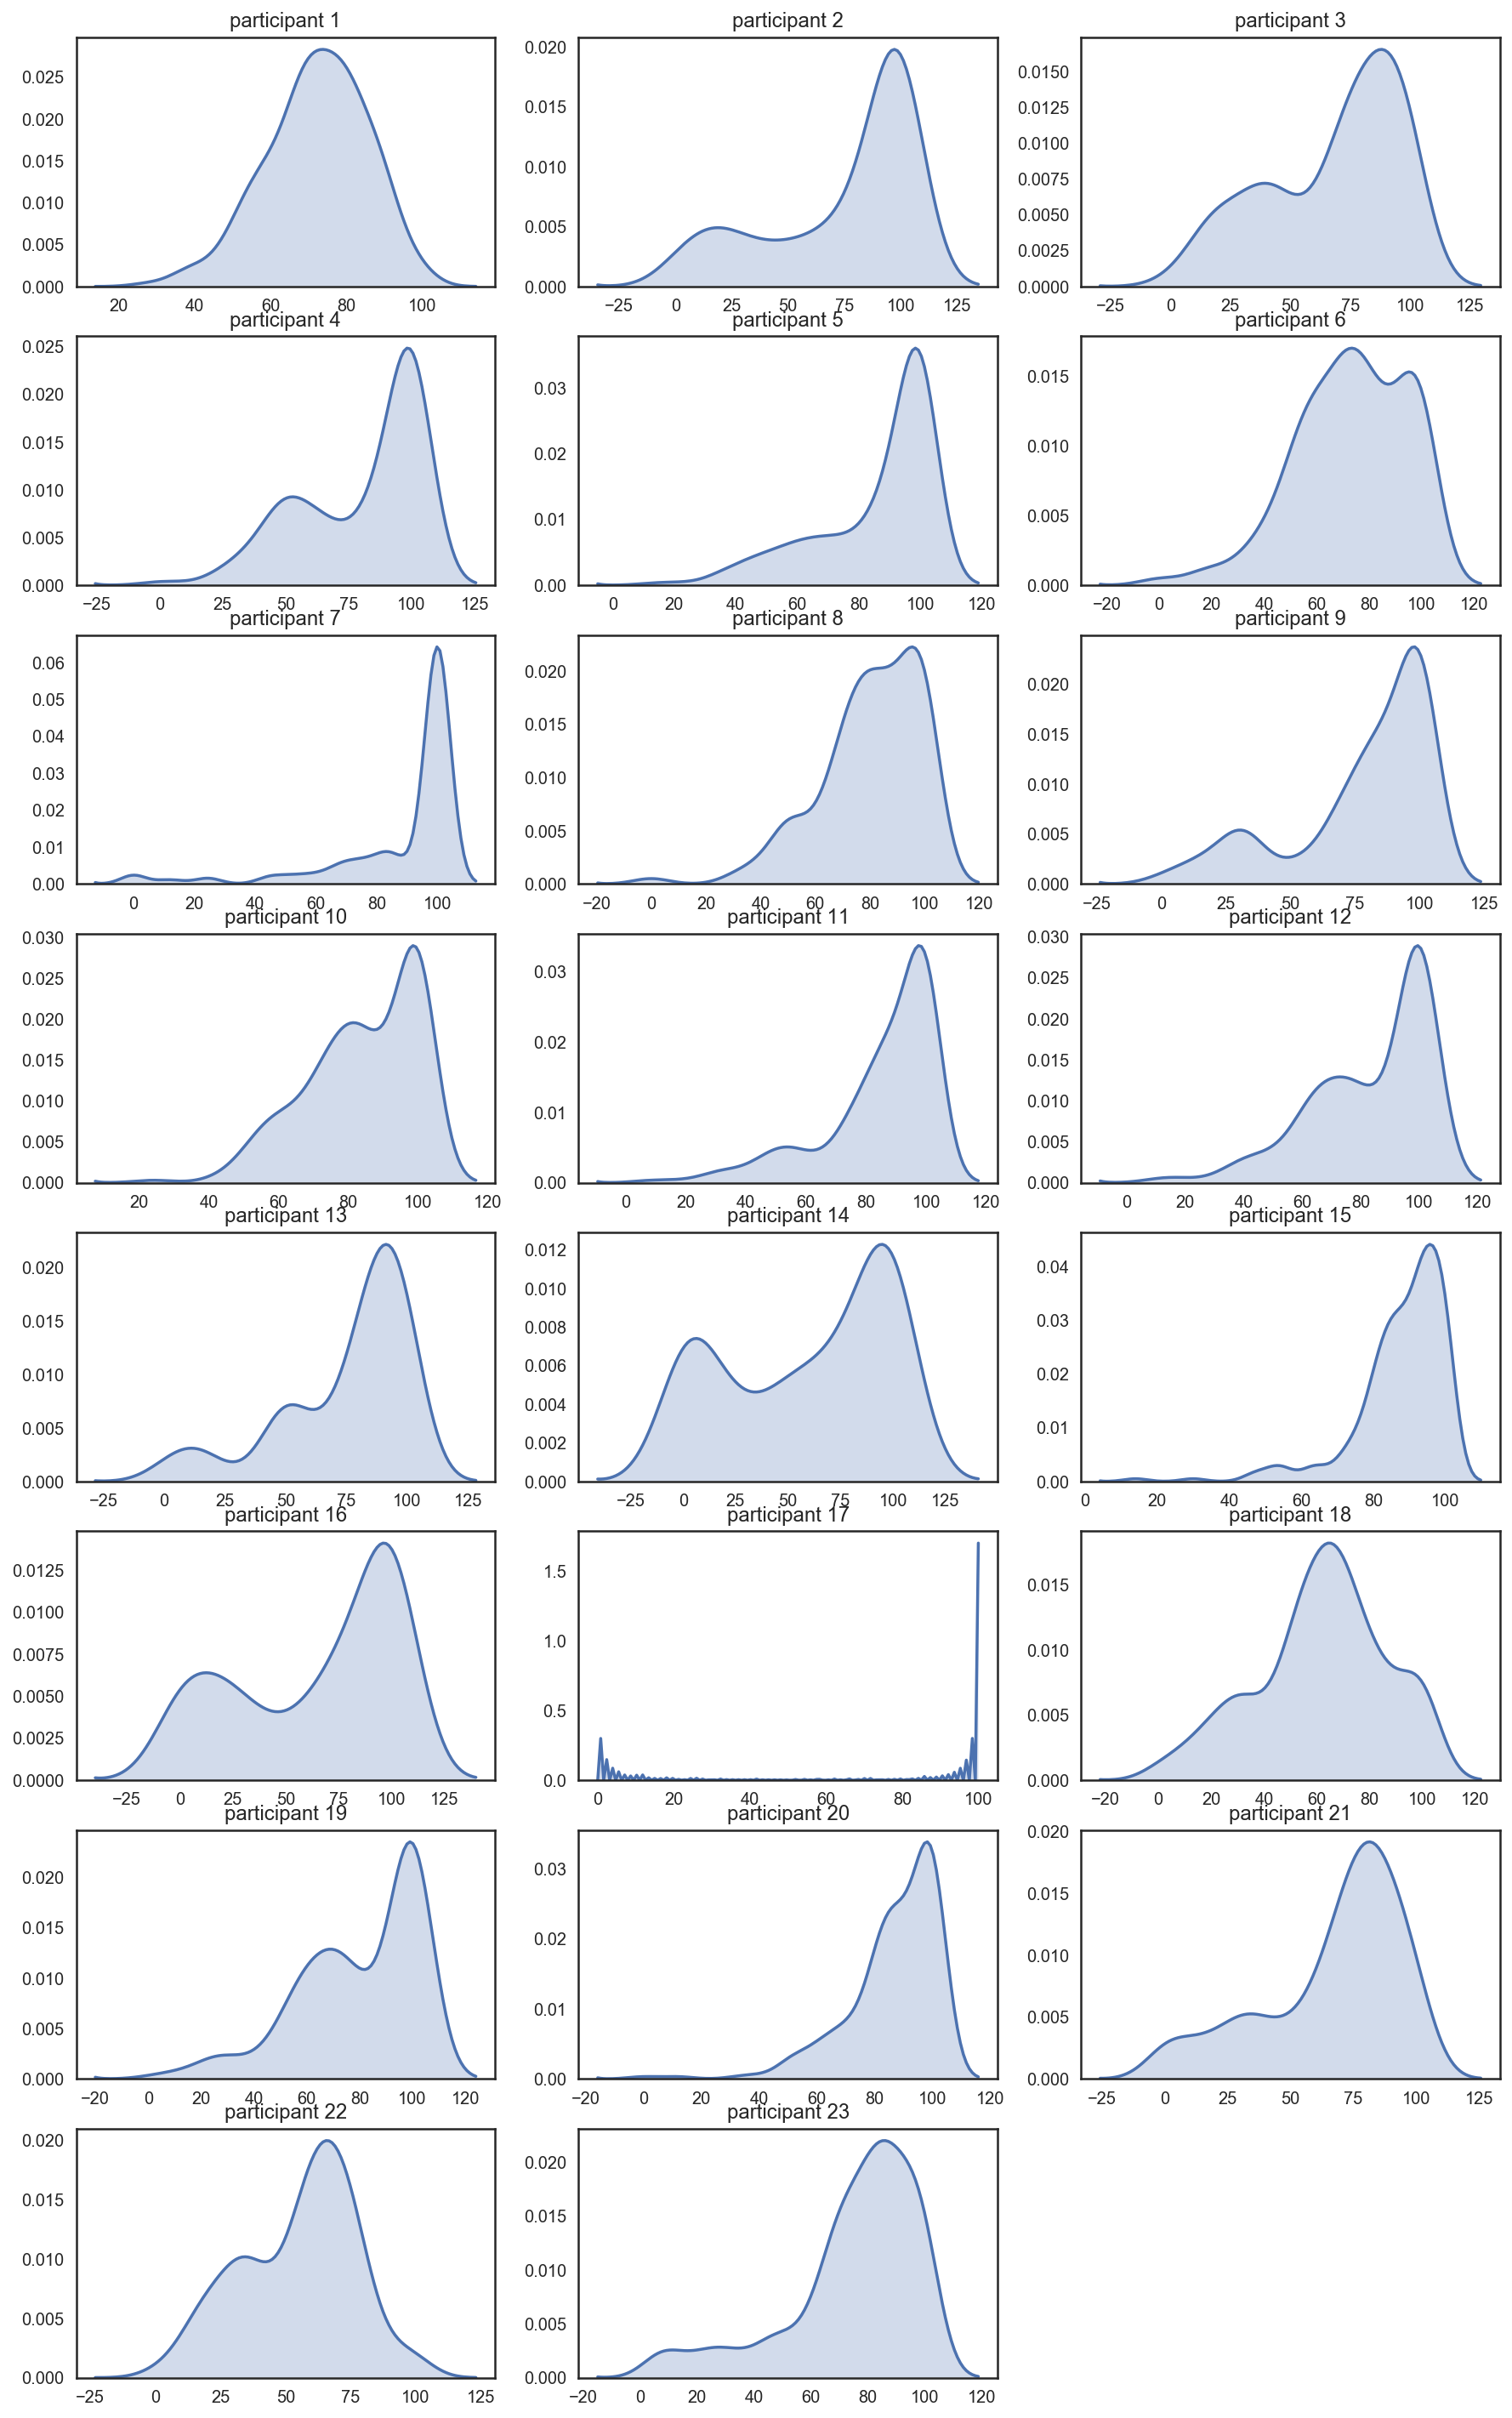

In [20]:
participant_densities(DataFrameSum1,'Conf')

## Choice RT distributions

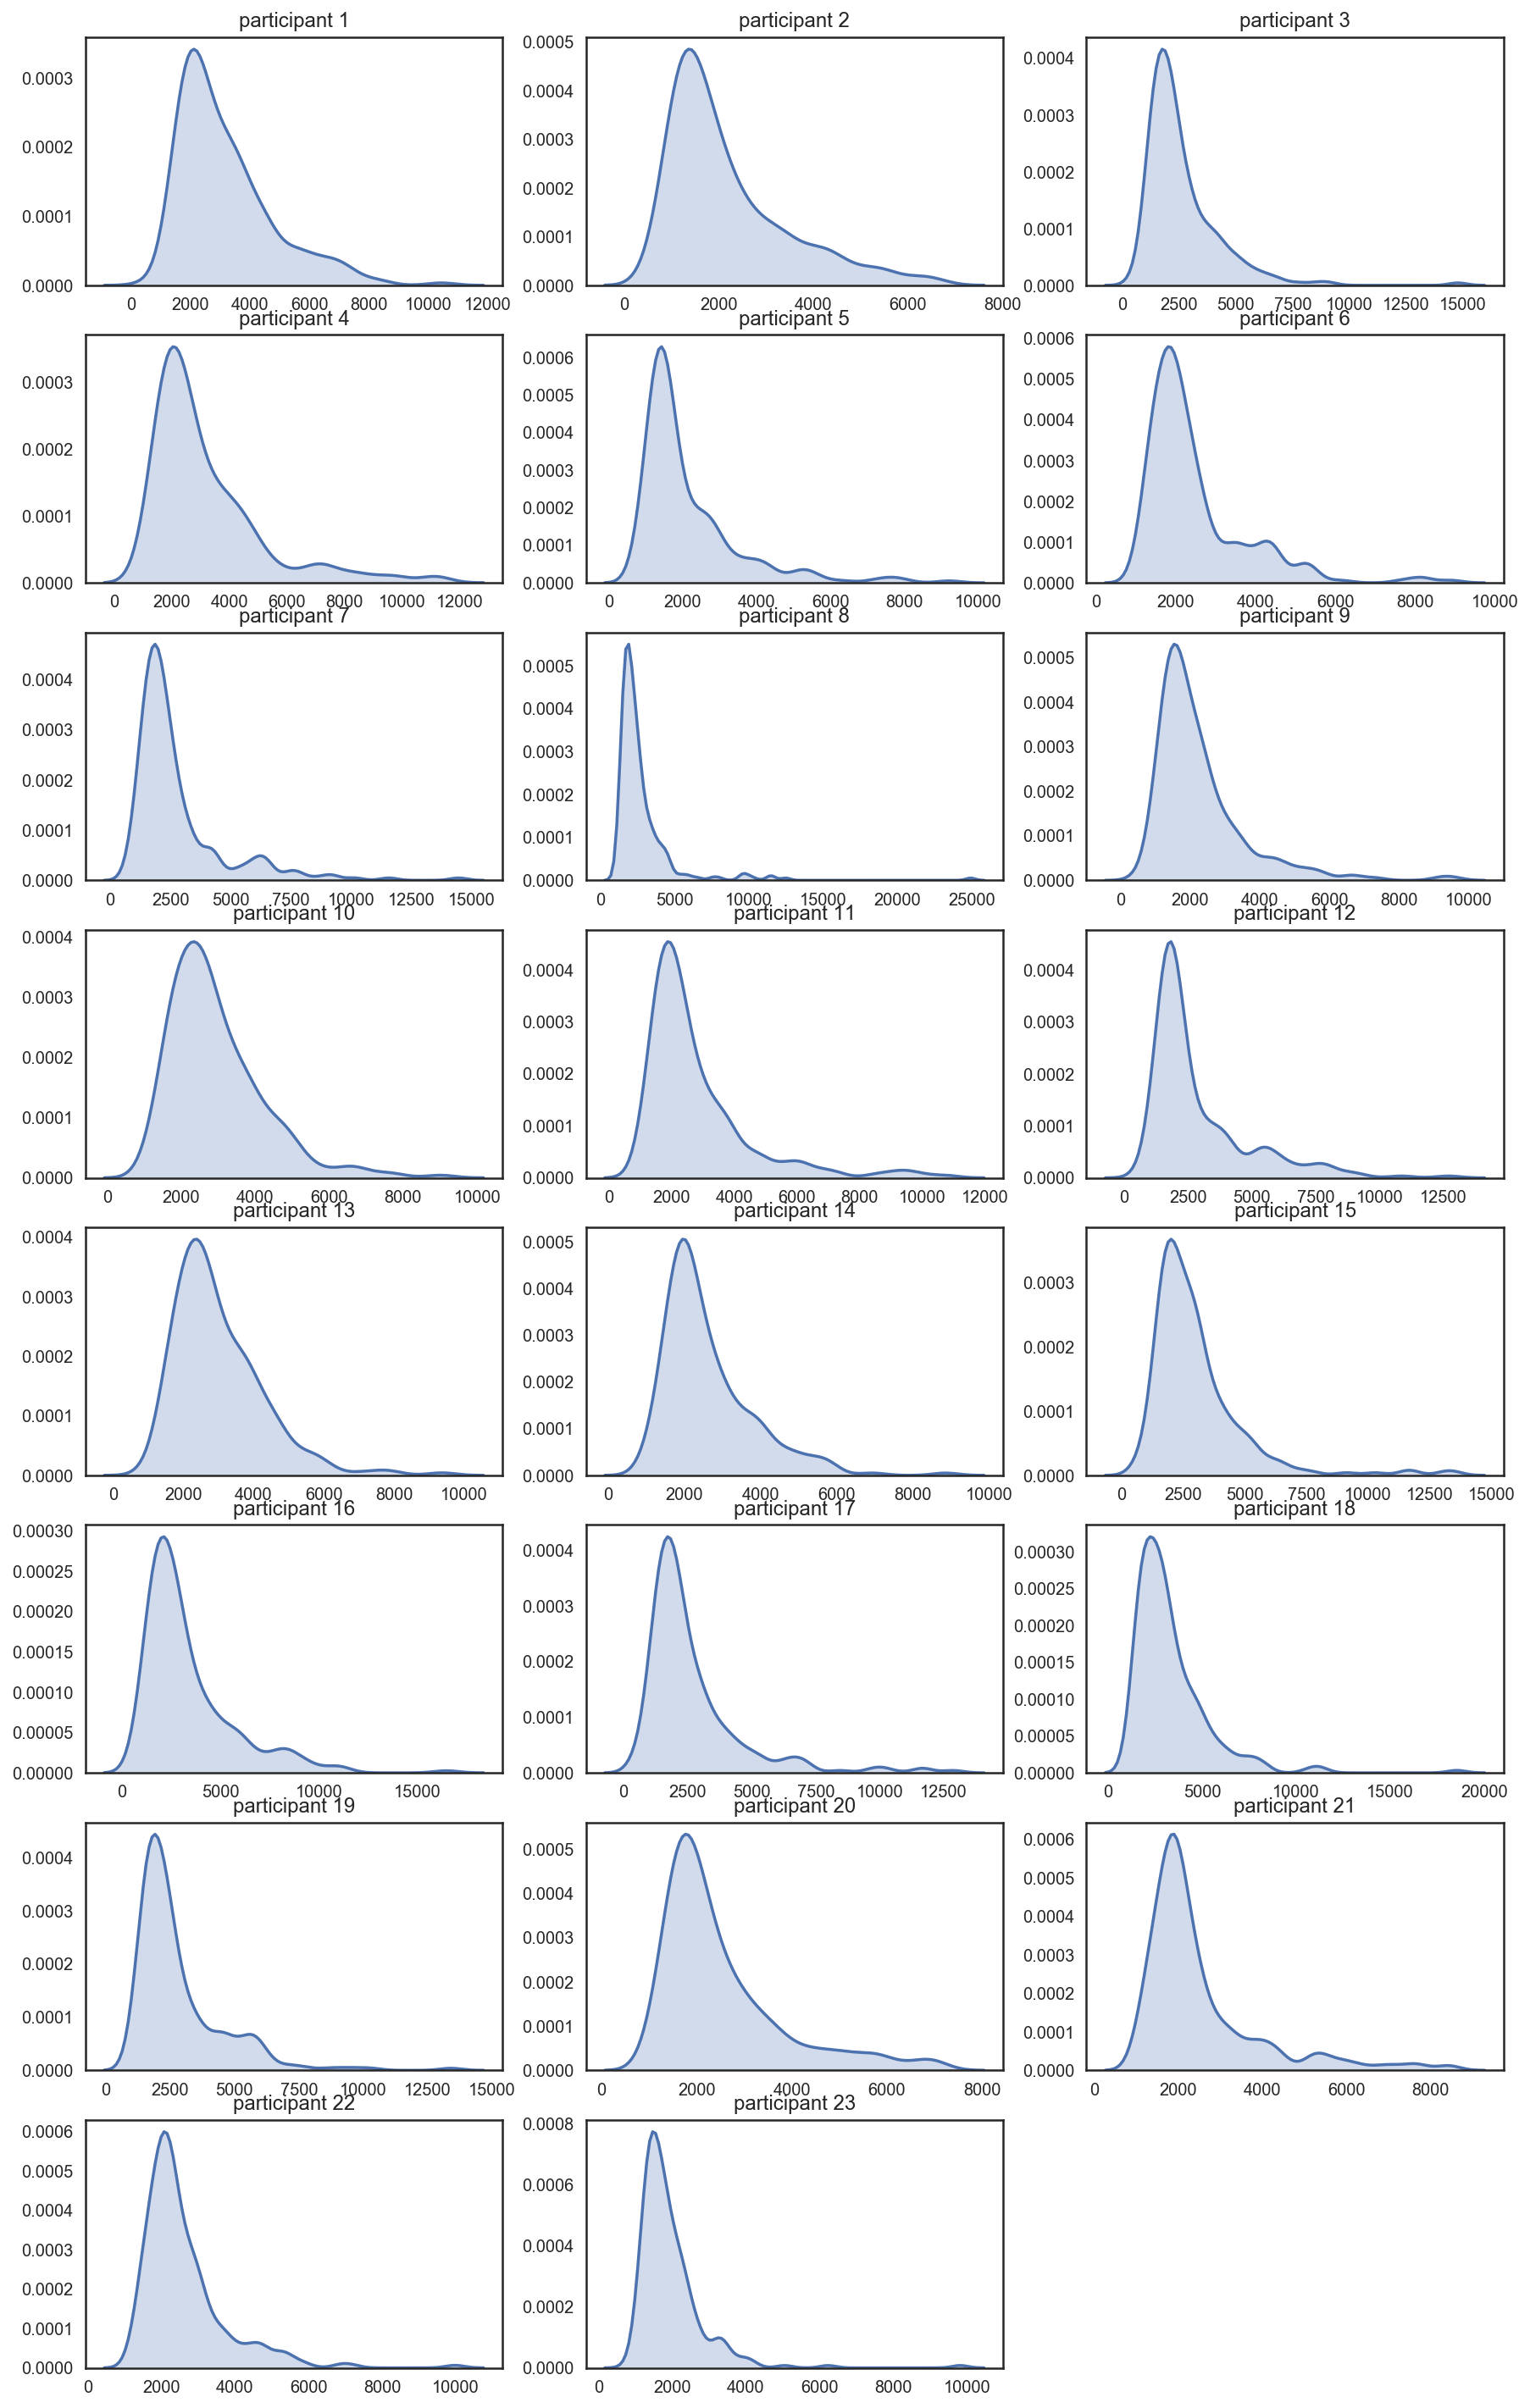

In [21]:
participant_densities(DataFrameSum1,'ChoiceRT',)

## Trial DDT distributions

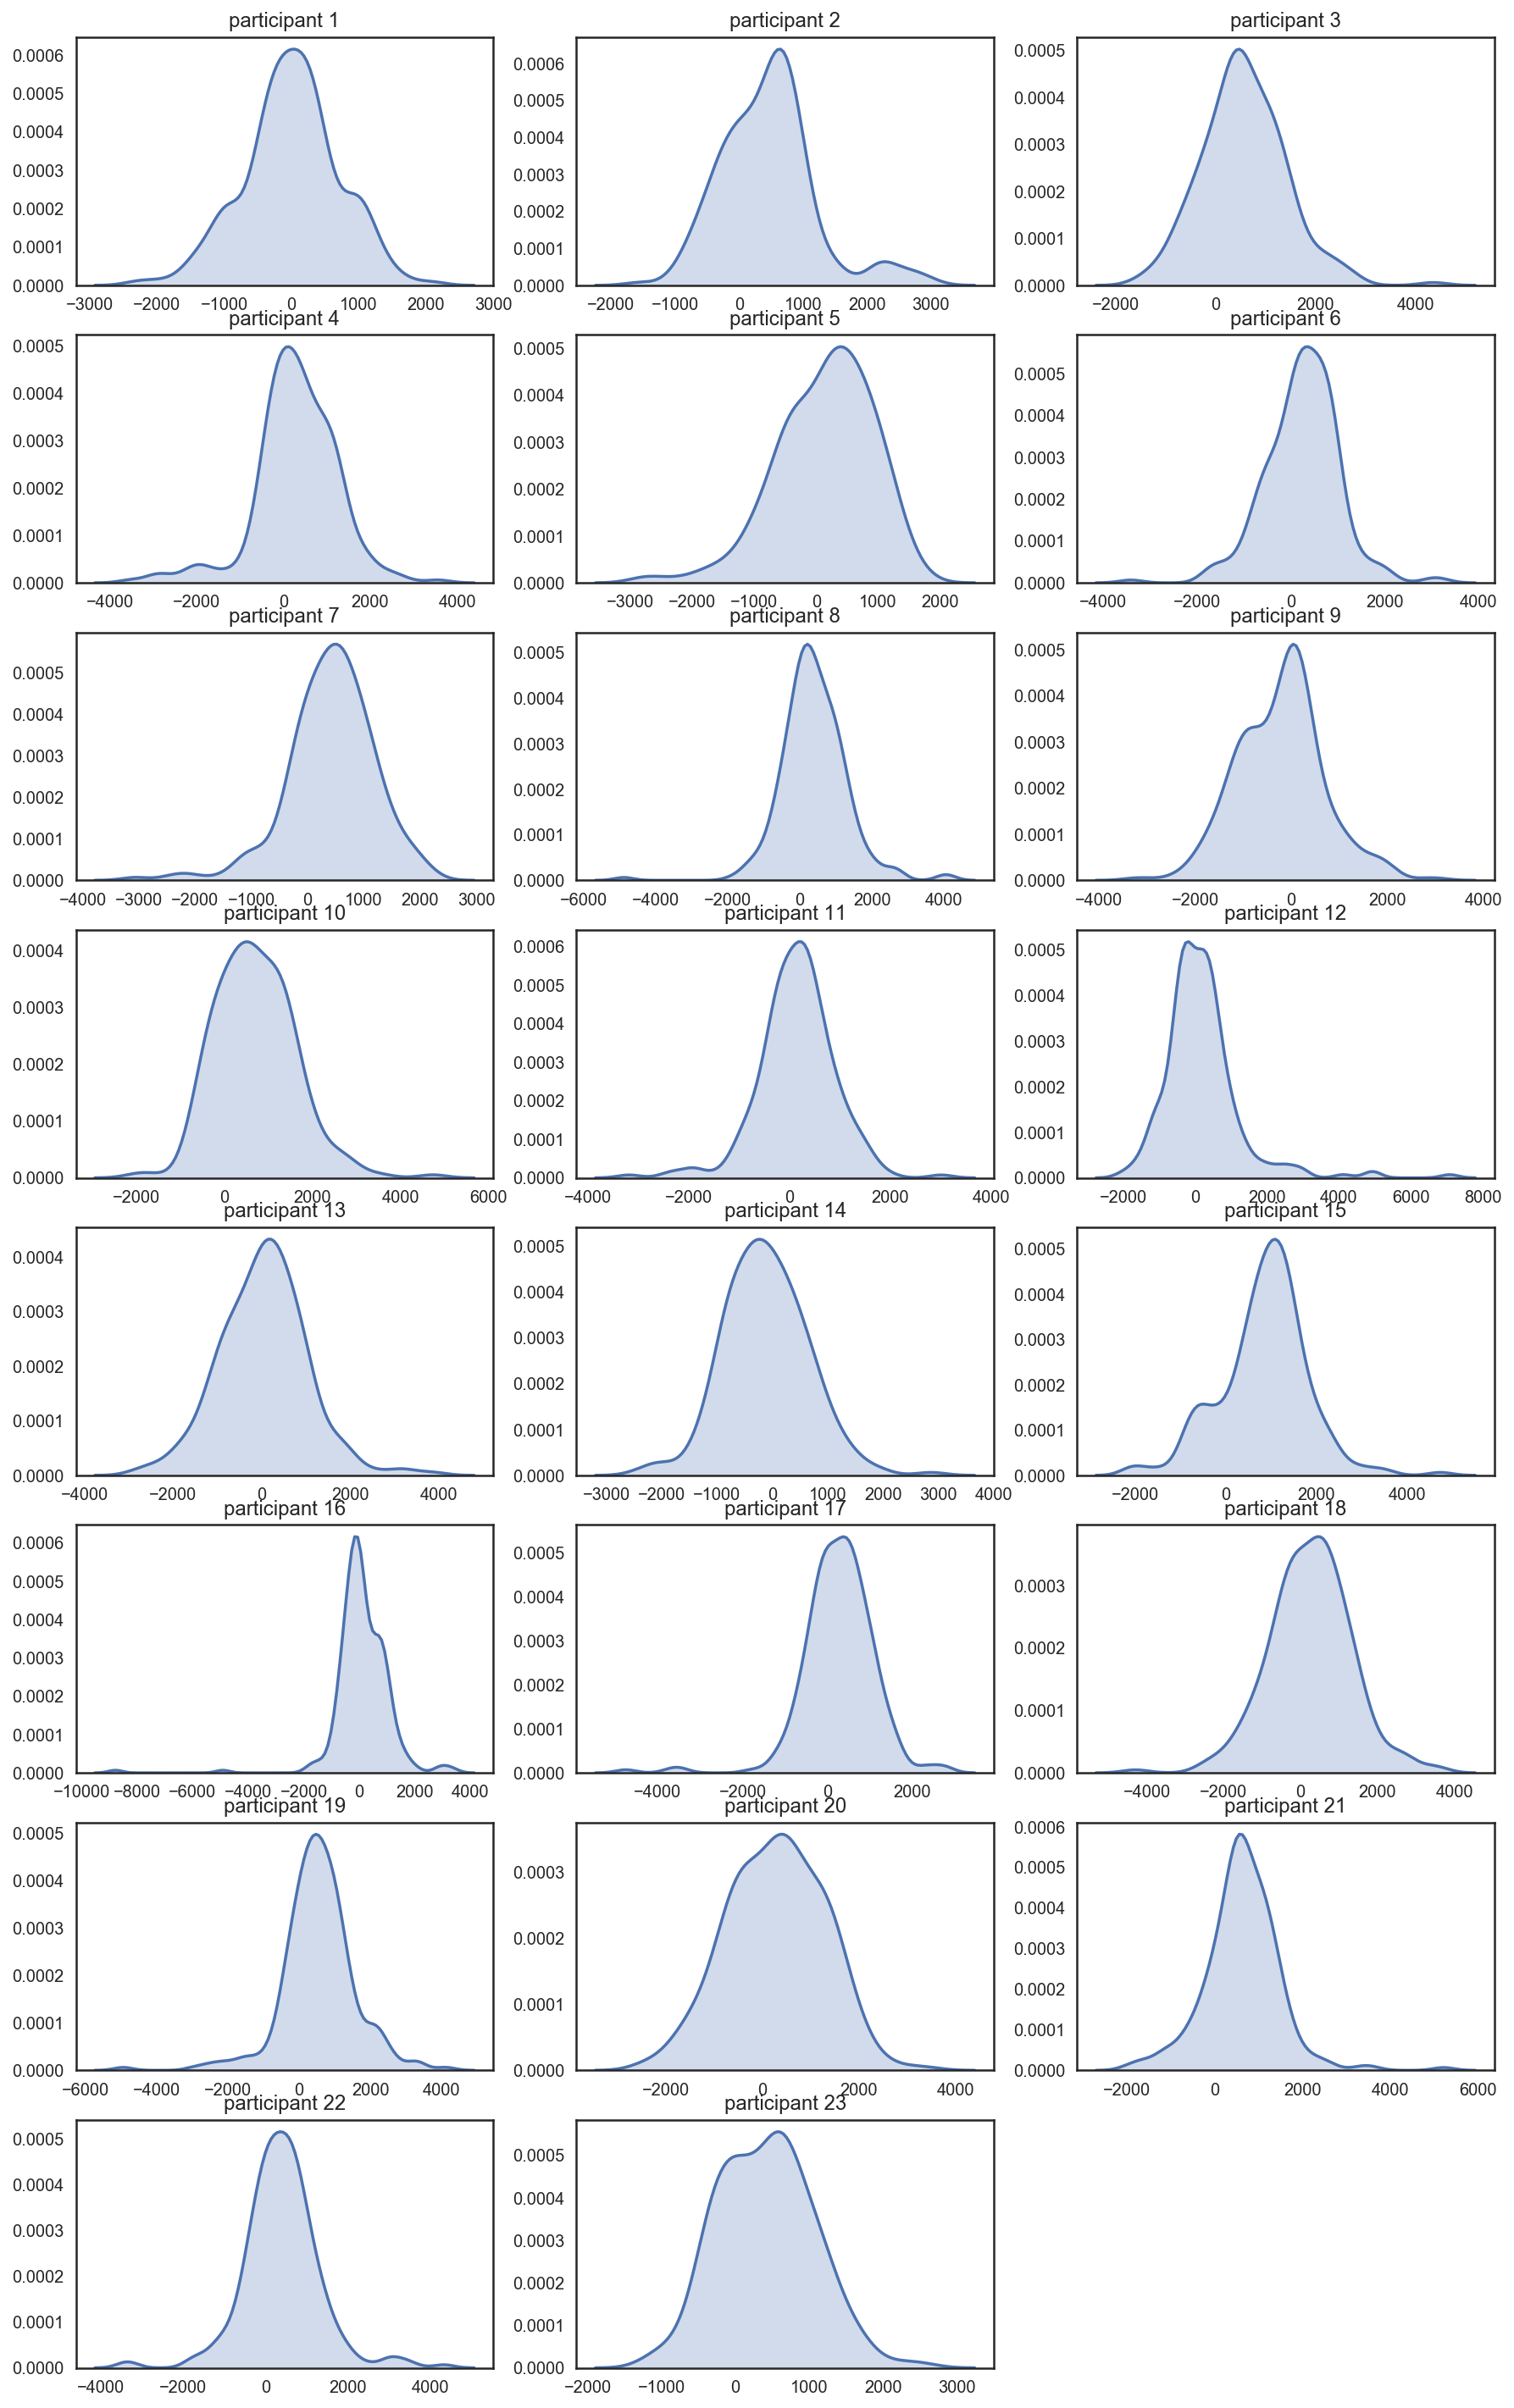

In [22]:
participant_densities(DataFrameSum1,'tDDT')

##  Item value distributions

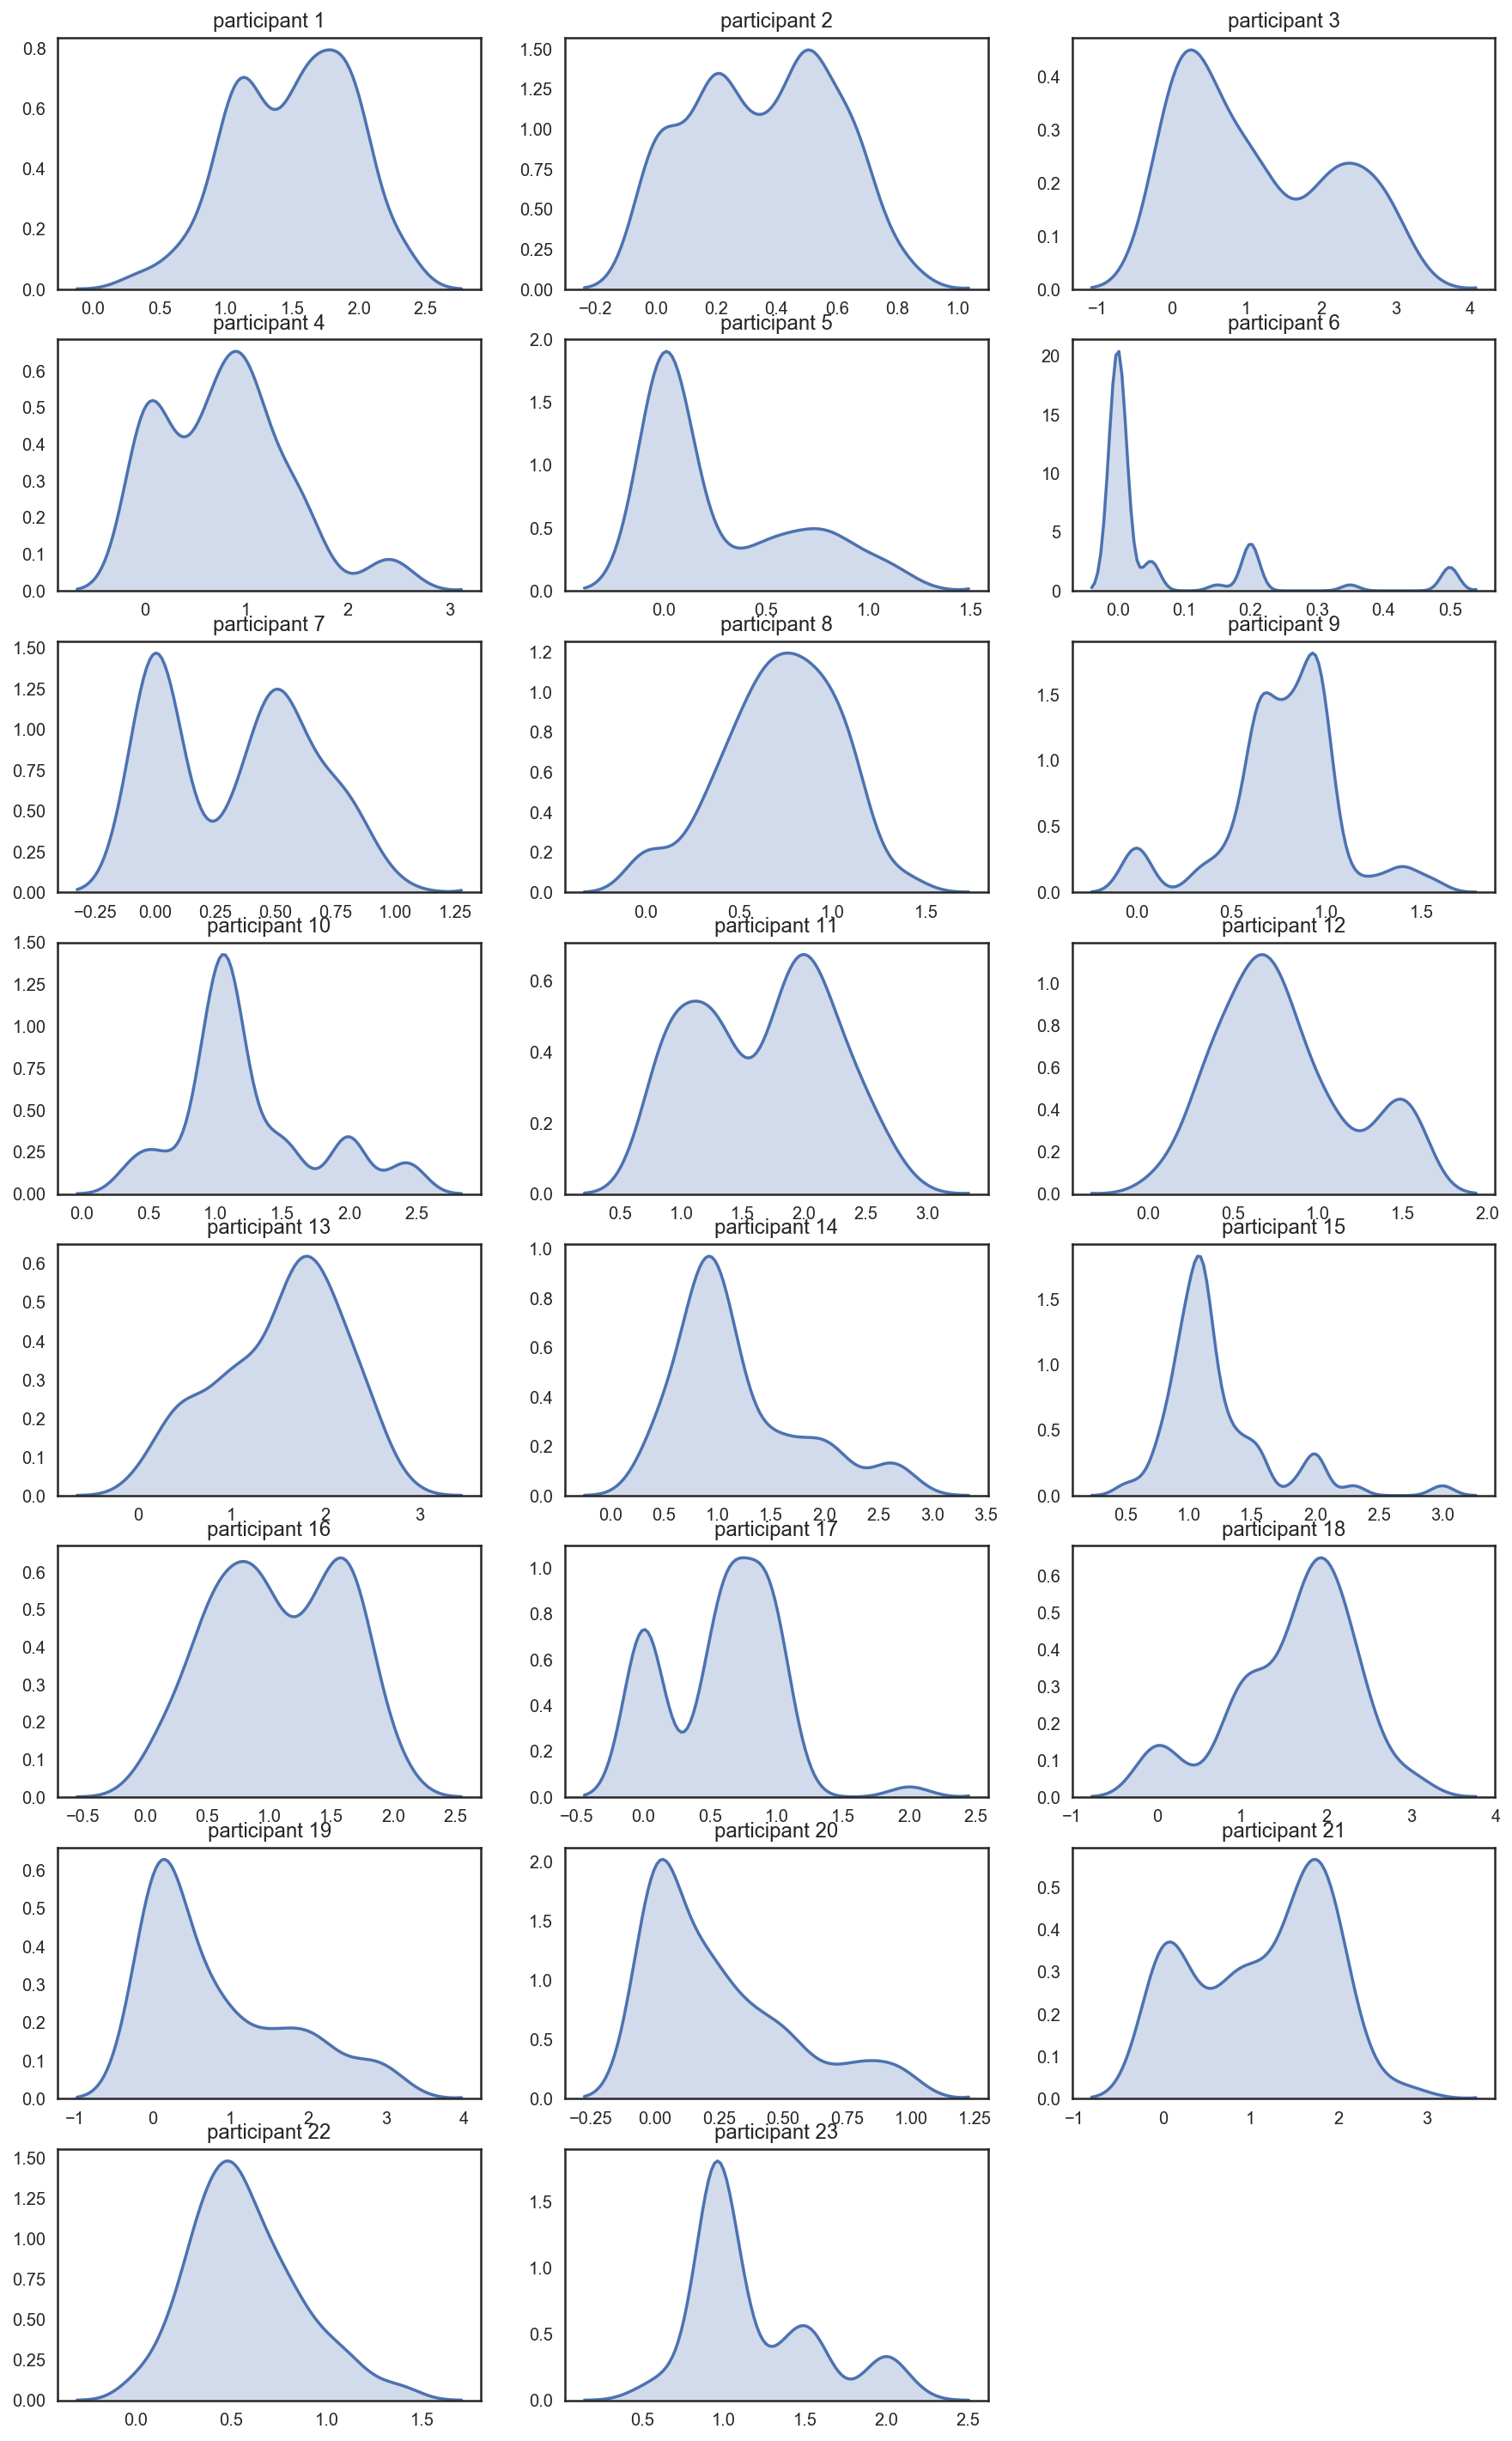

In [23]:
participant_densities(DataFrameSum1,'R_Value') # Distribution of value of items 
#(Right and left distributions are identical since we have the permutation)

## Trial GSF

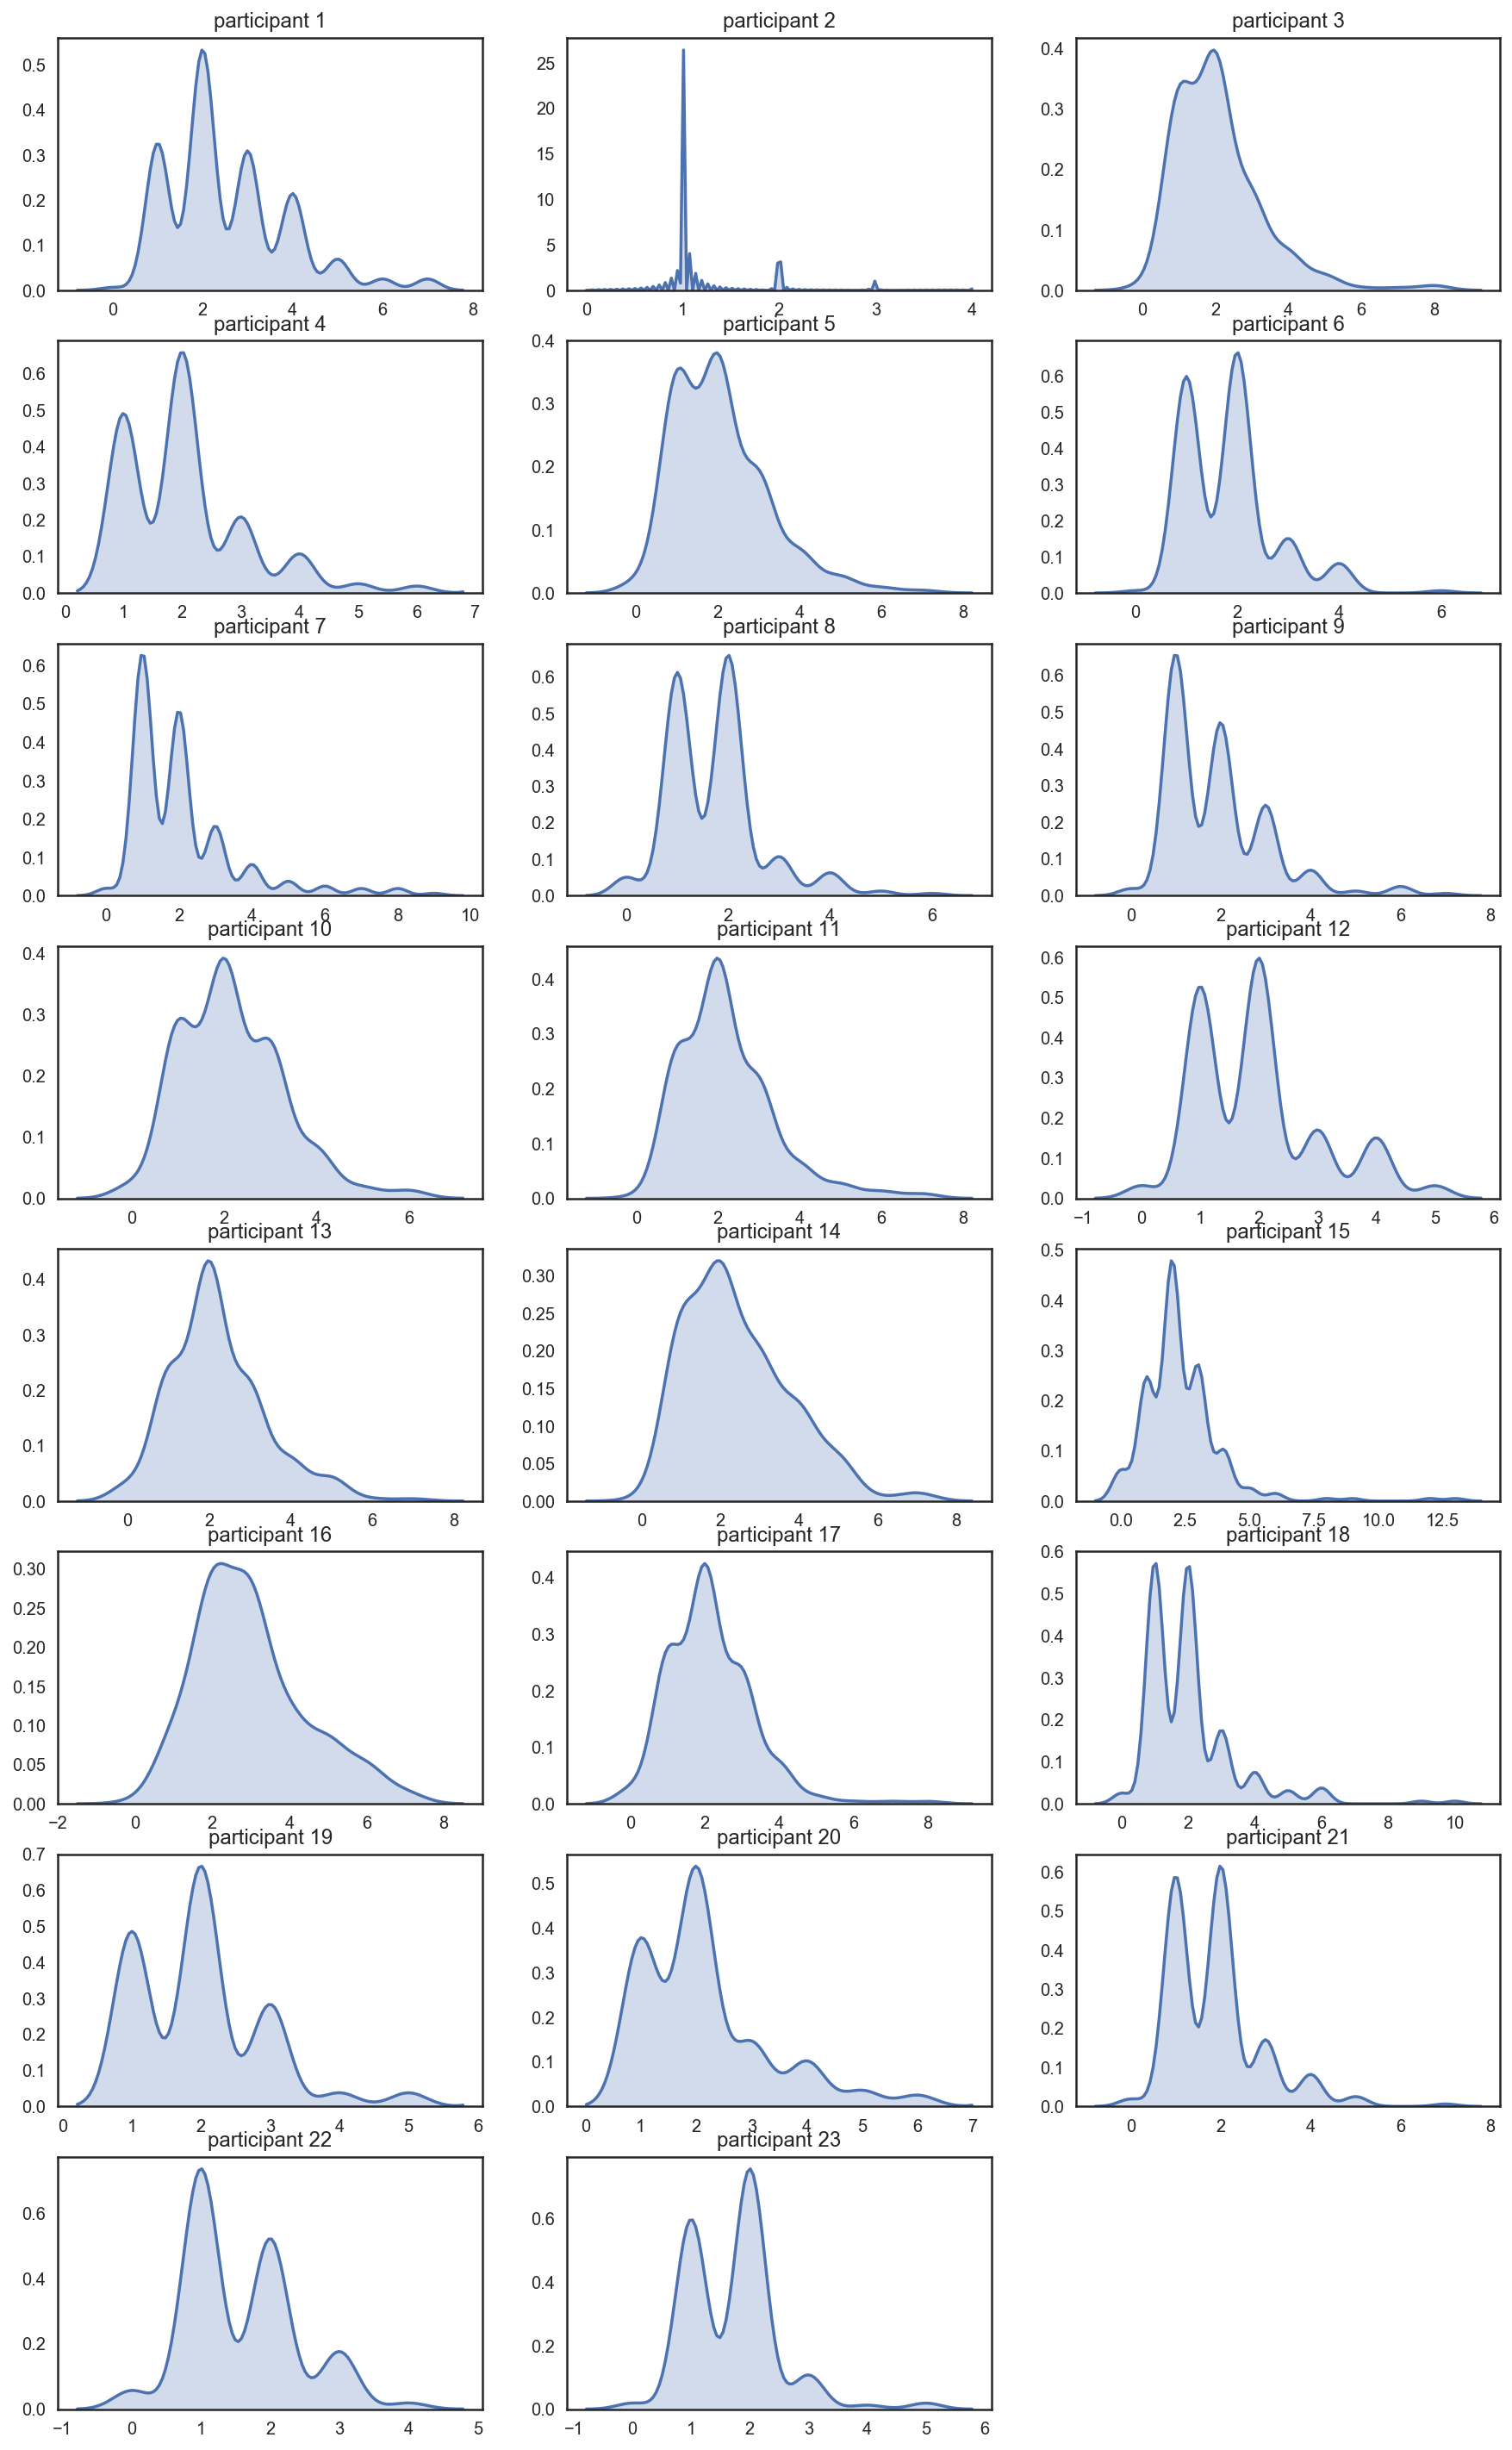

In [24]:
participant_densities(DataFrameSum1,'tGSF')

<a id='zfam'></a>
# Calculate Z-scores 

In [25]:
# Calculate Z-values and other 
z_matrix=[]
z_matrix_aux=[]

for i in (DataFrameSum1['Part'].unique()):
    Choicedata = DataFrameSum1.loc[DataFrameSum1['Part'] == str(i)]
    # from v3 and on we define DV as  RIGHT - LEFT values of the items
    pX_DV = - pd.to_numeric(Choicedata["L_Value"]) + pd.to_numeric(Choicedata["R_Value"])
    pX_zDV = (pX_DV - np.mean(pX_DV))/np.std(pX_DV)
    pX_absDV = abs(- pd.to_numeric(Choicedata['L_Value']) + pd.to_numeric(Choicedata['R_Value']))
    pX_zAbsDV = (pX_absDV - np.mean(pX_absDV))/np.std(pX_absDV)
    pX_zConf = (pd.to_numeric(Choicedata['Conf']) - np.mean(pd.to_numeric(Choicedata['Conf'])))/np.std(pd.to_numeric(Choicedata['Conf']))
    pX_zChoiceRT = (pd.to_numeric(Choicedata['ChoiceRT'] )- np.mean(pd.to_numeric(Choicedata['ChoiceRT'])))/np.std(pd.to_numeric(Choicedata['ChoiceRT']))
    
    
    z_matrix_aux= np.column_stack((pX_DV,pX_zDV,pX_absDV,pX_zAbsDV,pX_zConf,pX_zChoiceRT))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])

In [26]:
Final_trial = np.column_stack((DDT_GSF_trial,z_matrix))
Final_head = np.insert(Final_trial,  0, np.array(('Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat','DV','zDV','absDV','zAbsDV','zConf','zChoiceRT')), axis=0)
Final_head

array([['Part', 'TrialN', 'PairID', ..., 'zAbsDV', 'zConf', 'zChoiceRT'],
       ['1', '1', '14', ..., '1.5175525332012054',
        '-0.016205609317923964', '0.09811172039487039'],
       ['1', '2', '44', ..., '0.26452750578736517',
        '-0.3153860890334407', '0.15917416794981182'],
       ...,
       ['23', '238', '53', ..., '-1.0397440652420815',
        '0.8235334281517316', '-0.882515797000614'],
       ['23', '239', '11', ..., '-0.6546536707079768',
        '-0.7226049506468261', '-0.32020584393265944'],
       ['23', '240', '54', ..., '1.655888696496649',
        '0.0504642387524528', '-0.6605216872723834']], dtype='<U36')

In [27]:
#save text file with DDT and GSF for each participant/trial
#np.savetxt("DataFoodFramingNotebook_v1.csv", Final_head, delimiter=",", fmt='%s')

## Extract familiarity information from the BDM and add it to each trial in the choice step of the experiment

## Load data in python - Choice Data

In [28]:
#Load choice trial values (saved in previous stage)

#LOAD FROM FILE
#data_exp1 = pd.read_csv('/Users/bdmlab/Google Drive/BdM Projects/FoodFraming_Amy/Analysis Scripts/DataFoodFramingNotebook_v1.csv') # The main data file for the first

#CONTINUE USING DATASET FROM PREVIOUS STAGE
data_exp1 = pd.DataFrame(Final_trial,columns = ['Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat','DV','zDV','absDV','zAbsDV','zConf','zChoiceRT'])

data_exp1.head()

Part TrialN PairID                        L_Item L_Value  \
0    1      1     14        116_boots_caramels.png    0.95   
1    1      2     44  102_propercorn_worcester.png     2.3   
2    1      3     51               59_crunchie.png     1.7   
3    1      4     12       64_nestle_aero_mint.png    1.55   
4    1      5      4   44_walkers_french_fries.png     2.0   

                           R_Item R_Value ChosenITM ChoiceRT Conf  \
0               31_beef_jerky.png     2.0         1     3327   72   
1                   26_yorkie.png     1.7         1     3424   68   
2                 5_caramello.png    1.25         1     3691   68   
3    102_propercorn_worcester.png     2.3         0     8144   68   
4  111_propercorn_sweetnsalty.png     2.0         0     6559   88   

          ...          L_IA_DT R_IA_DT tGSF lastFixat                    DV  \
0         ...             1874    1186    3         1                  1.05   
1         ...             1206    1770    3         2   -0.5999999999999999   
2         ...             1020    2091    1         2  -0.44999999999999996   
3         ...             4153    2660    4         1    0.7499999999999998   
4         ...             4063    2024    4         1                   0.0   

                      zDV                absDV                zAbsDV  \
0      1.6944302139657446                 1.05    1.5175525332012054   
1     -0.9682458365518538   0.5999999999999999   0.26452750578736517   
2     -0.7261843774138904  0.44999999999999996  -0.15314750335058117   
3       1.210307295689817   0.7499999999999998    0.6822025149253115   
4  1.0451085762029445e-17                  0.0   -1.4061725307644208   

                   zConf            zChoiceRT  
0  -0.016205609317923964  0.09811172039487039  
1    -0.3153860890334407  0.15917416794981182  
2    -0.3153860890334407   0.3272532761680527  
3    -0.3153860890334407     3.13046027577789  
4     1.1805163095441429    2.132687292534775  

[5 rows x 23 columns]

In [29]:
len(data_exp1)

5520

## Load data in python - BDM data

In [30]:
#Extract BDM data from all the subject folders (Separated folder for each participant, each one containing the file "BDM_RESULTS_FILE.txt")

#INPUT PATH FOR BDM_RESULTS_FILE folder
main_path = "/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/"
file_list = os.listdir(main_path)

print("File List in Folder")
print(sorted(file_list))

File List in Folder
['.DS_Store', 'p1', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p5', 'p6', 'p7', 'p8', 'p9']


In [31]:
file_array = []

for k in range(len(participant_names)):
        BDM_filename = "/BDM_RESULTS_FILE.txt"
        files =  main_path + participant_names[k] + BDM_filename
        file_array.append(files) 
        
print("number of files to load:" ,len(file_array))        
file_array
#Make sure that the paths are properly defined 

number of files to load: 23


['/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p1/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p5/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p6/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p7/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p8/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p9/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p10/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue

In [32]:
#define partipant names(numbers)
participant = (data_exp1['Part'].unique())
participant

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype=object)

### Adding familiarity values and new variables

In [33]:
FamLeft  = []
FamRight = []
Tot_Fam = []
FamChosen = []
FamUnChosen = []
ValChosen = []
ValUnChosen = []
Tot_Val = []
Correct_val = []
correct = []

trial_count = 0

#for cycle for participant
for k in range(0,len(file_array)):
    BDMframe = [pd.read_csv(file_array[k], sep="\t")]
    BDMdata = pd.concat(BDMframe)
    
    #for cycle for trials 
    data_part = data_exp1.loc[(data_exp1['Part'] == str(participant[k]))]
    trial_n = data_part['TrialN'].unique()
    #print(data_part)

    for  j in range(len(trial_n)):    
        #Pick identity left item  
    
        L_item_name = data_part['L_Item'][trial_count]
        FamValue_L = BDMdata.loc[(BDMdata['BDM_ITM']== L_item_name),'BDM_FAM'].values[0]
        Value_L = BDMdata.loc[(BDMdata['BDM_ITM']== L_item_name),'BDM_VAL'].values[0]
        
        #Pick identity right item
        
        R_item_name = data_part['R_Item'][trial_count]
        FamValue_R = BDMdata.loc[(BDMdata['BDM_ITM']== R_item_name),'BDM_FAM'].values[0]
        Value_R = BDMdata.loc[(BDMdata['BDM_ITM']== R_item_name),'BDM_VAL'].values[0]
        
        
        ChosenITMtrial = data_part['ChosenITM'][trial_count]
        BlockCondtrial = data_part['BlockCond'][trial_count]

        if ChosenITMtrial == "1":  #Selected Item is Right
            FamChosenT  = FamValue_R
            FamUnChosenT  = FamValue_L
            ValUnChosenT  = Value_L
            ValChosenT  = Value_R
            
            if BlockCondtrial == "1.0": # Block is like, correct chosen is higher value
                if Value_R >= Value_L:
                    correct = 1
                else: 
                    correct = 0
            
            if BlockCondtrial == "2.0" :# Block is dislike, correct chosen is lower value
                if Value_L >= Value_R:
                    correct = 1
                else: 
                    correct = 0  
                
        else: # Selected item is Left
            FamChosenT  = FamValue_L
            FamUnChosenT  = FamValue_R
            ValUnChosenT  = Value_R           
            ValChosenT = Value_L
            
            if BlockCondtrial == "1.0": # Block is like, correct chosen is higher value
                if Value_L >= Value_R:
                    correct = 1
                else: 
                    correct = 0
            
            if BlockCondtrial == "2.0" :# Block is dislike, correct chosen is lower value
                if Value_R >= Value_L:
                    correct = 1
                else: 
                    correct = 0  
        
        FamValTot = FamValue_L + FamValue_R
        
        ValTot = Value_L + Value_R
        
        #add to the rows with current trial measures
        FamLeft.append(str(FamValue_L))
        FamRight.append(str(FamValue_R))
        Tot_Fam.append(str(FamValTot))
        Tot_Val.append(str(ValTot))    
        FamChosen.append(str(FamChosenT))
        FamUnChosen.append(str(FamUnChosenT))
        ValChosen.append(str(ValChosenT))
        ValUnChosen.append(str(ValUnChosenT))
        Correct_val.append(str(correct))

        trial_count = trial_count + 1
        


In [34]:
# stack columns for the new familiarity values
table_aux= np.column_stack((FamLeft,FamRight,Tot_Fam,Tot_Val,FamChosen,FamUnChosen,ValChosen,ValUnChosen,Correct_val))
table_aux

array([['1.08', '4.83', '5.91', ..., '2.0', '0.95', '0'],
       ['4.83', '3.58', '8.41', ..., '1.7', '2.3', '1'],
       ['5.0', '2.83', '7.83', ..., '1.25', '1.7', '1'],
       ...,
       ['1.83', '5.0', '6.83', ..., '0.95', '0.95', '1'],
       ['0.0', '2.58', '2.58', ..., '0.95', '1.1', '0'],
       ['3.08', '1.33', '4.41', ..., '2.0', '0.95', '1']], dtype='<U19')

In [35]:
# Check similar size for both tables
print(len(table_aux))
print(len(data_exp1))

5520
5520


In [36]:
Fam_part = pd.DataFrame(table_aux,columns=['FamLeft','FamRight','Tot_Fam','Tot_Val','FamChosen','FamUnChosen','ValChosen','ValUnChosen','Correct'])
new_data = pd.concat([data_exp1, Fam_part],axis =1)

# Agregate data matrix
new_data = new_data.apply(pd.to_numeric, errors='ignore')

z_matrix=[]
z_matrix_aux=[]

In [37]:
#Calculate Z-values for familiarity and (un)Chosen values
for i in unique(new_data["Part"]):
    Choicedata = new_data.loc[new_data['Part'] == i]
    pX_totFam = pd.to_numeric(Choicedata['Tot_Fam'])
    z_totFam = (pX_totFam - np.mean(pX_totFam))/np.std(pX_totFam)

    pX_totVal = pd.to_numeric(Choicedata['Tot_Val'])
    z_totVal = (pX_totVal - np.mean(pX_totVal))/np.std(pX_totVal)
    
    pX_ValChosen = pd.to_numeric(Choicedata['ValChosen'])
    z_ValChosen = (pX_ValChosen - np.mean(pX_ValChosen))/np.std(pX_ValChosen)

    pX_ValUnChosen = pd.to_numeric(Choicedata['ValUnChosen'])
    z_ValUnChosen = (pX_ValUnChosen - np.mean(pX_ValUnChosen))/np.std(pX_ValUnChosen)

    pX_FamChosen = pd.to_numeric(Choicedata['FamChosen'])
    z_FamChosen = (pX_FamChosen - np.mean(pX_FamChosen))/np.std(pX_FamChosen)

    pX_FamUnChosen = pd.to_numeric(Choicedata['FamUnChosen'])
    z_FamUnChosen = (pX_FamUnChosen - np.mean(pX_FamUnChosen))/np.std(pX_FamUnChosen)
    
    pX_tGSF = pd.to_numeric(Choicedata['tGSF'])
    z_tGSF = (pX_tGSF - np.mean(pX_tGSF))/np.std(pX_tGSF)
    
    pX_tDDT = pd.to_numeric(Choicedata['tDDT'])
    z_tDDT = (pX_tDDT - np.mean(pX_tDDT))/np.std(pX_tDDT)

    absDDT = abs(z_tDDT)
    
    z_matrix_aux= np.column_stack((z_totFam,z_totVal,z_ValChosen,z_ValUnChosen,z_FamChosen,z_FamUnChosen, z_tGSF, z_tDDT, absDDT))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])

In [38]:
Zmatrix_part = pd.DataFrame(z_matrix,columns=['ZtotFam','ZtotVal','ZValCh','ZValUnCh','ZFamCh','ZFamUnCh', 'ztGSF', 'ztDDT', 'absDDT'])

<a id='split'></a>
# Including Median Split Data

### Confidence Split

In [39]:
# Calculate median for the confidence split for each participant
median_matrix=[]
median_matrix_aux=[]
for i in unique(new_data["Part"]):
    Splitdata = new_data.loc[new_data['Part'] == i]
     # Select the column to split
    Splitdata = Splitdata.loc[:,['TrialN','Conf']]
    #print(Splitdata)
    SplitSort = Splitdata.values
    # Sort for confidence column
    SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
    #print(SplitSort)
    lenPart = len(Splitdata)
    #print(lenPart)
    # Generate column with median order
    median_low = [0] * int (lenPart/2)
    #print (median_low)
    median_high = [1] * int (lenPart/2)
    #print (median_high)
    median_split_order = median_low + median_high
    #Attach split order columns
    median_aux= np.column_stack((SplitSort,median_split_order))
    #Sort back to trial number
    SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
    #Extract only the column
    median_matrix_aux = SplitSorted[:,2]
    #print(median_matrix_aux)

    #If split for other variables want to be added, copy block above changing the desired variable in Splitdata
    
    
    for  j in range(len(median_matrix_aux)):    
        median_matrix.append(median_matrix_aux [j])

### GSF Split

In [40]:
# Split high/low gaze shift frequency
GSFsplit_matrix=[]
GSPsplit_matrix_aux=[]
for i in unique(new_data["Part"]):
    Splitdata = data_exp1.loc[new_data['Part'] == i]
     # Select the column to split
    Splitdata = Splitdata.loc[:,['TrialN','tGSF']]
    SplitSort = Splitdata.values
    # Sort for confidence column
    SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
    lenPart = len(Splitdata)
    #print(lenPart)
    # Generate column with median order
    median_low = [0] * int (lenPart/2)
    #print (median_low)
    median_high = [1] * int (lenPart/2)
    #print (median_high)
    median_split_order = median_low + median_high
    #Attach split order columns
    median_aux= np.column_stack((SplitSort,median_split_order))
    #Sort back to trial number
    SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
    #Extract only the column
    GSPsplit_matrix_aux = SplitSorted[:,2]
    #print(GSPsplit_matrix_aux)
    
    for  j in range(len(GSPsplit_matrix_aux)):    
        GSFsplit_matrix.append(GSPsplit_matrix_aux [j])

### DDT Split

In [41]:
# Split high/low dwell time
DDTsplit_matrix=[]
DDTsplit_matrix_aux=[]
for i in unique(new_data["Part"]):
    Splitdata = data_exp1.loc[new_data['Part'] == i]
     # Select the column to split
    Splitdata = Splitdata.loc[:,['TrialN','tDDT']]
    SplitSort = Splitdata.values
    # Sort for confidence column
    SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
    lenPart = len(Splitdata)
    #print(lenPart)
    # Generate column with median order
    median_low = [0] * int (lenPart/2)
    #print (median_low)
    median_high = [1] * int (lenPart/2)
    #print (median_high)
    median_split_order = median_low + median_high
    #Attach split order columns
    median_aux= np.column_stack((SplitSort,median_split_order))
    #Sort back to trial number
    SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
    #Extract only the column
    DDTsplit_matrix_aux = SplitSorted[:,2]
    #print(DDTsplit_matrix_aux)

    for  j in range(len(DDTsplit_matrix_aux)):    
        DDTsplit_matrix.append(DDTsplit_matrix_aux [j])

### AbsDDT split

In [42]:
#absDDT split
absDDTsplit_matrix=[]
absDDTsplit_matrix_aux=[]
for i in unique(new_data["Part"]):
    Splitdata1 = data_exp1.loc[new_data['Part'] == i]
     # Select the column to split
    Splitdata1 = Splitdata1.loc[:,['TrialN','abstDDT']]
    SplitSort1 = Splitdata1.values
    # Sort for confidence column
    SplitSort1 = SplitSort1[np.argsort(SplitSort1[:, 1])]
    lenPart1 = len(Splitdata1)
    #print(lenPart)
    # Generate column with median order
    median_low1 = [0] * int (lenPart1/2)
    #print (median_low)
    median_high1 = [1] * int (lenPart1/2)
    #print (median_high)
    median_split_order1 = median_low1 + median_high1
    #Attach split order columns
    median_aux1= np.column_stack((SplitSort1,median_split_order1))
    #Sort back to trial number
    SplitSorted1 = median_aux1[np.argsort(median_aux1[:, 0])]
    #Extract only the column
    absDDTsplit_matrix_aux = SplitSorted1[:,2]
    #print(DDTsplit_matrix_aux)

    for  j in range(len(absDDTsplit_matrix_aux)):    
        absDDTsplit_matrix.append(absDDTsplit_matrix_aux [j])

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [43]:
median_conf = pd.DataFrame(median_matrix,columns=['ConfSplit'])
median_DDT = pd.DataFrame(DDTsplit_matrix,columns=['DDTMedSplit'])
median_GSF = pd.DataFrame(GSFsplit_matrix,columns=['GSFMedSplit'])
median_absDDT = pd.DataFrame(absDDTsplit_matrix,columns=['absDDTMedSplit'])

#Join new familiarity and split datasets with the old trial information
data_exp1 = pd.concat([new_data, Zmatrix_part, median_conf, median_GSF, median_DDT, median_absDDT],axis =1)

#save text file with DDT and GSF for each participant/trial
data_exp1.to_csv("Output/DataFoodFramingNotebook_v1.csv")

# Data Analysis 
-------------------------------------------

## Load data from preparation step

In [44]:
figsize(15, 15)
#Transform to numeric values in the dataframe
data_exp1 = data_exp1.apply(pd.to_numeric, errors='ignore')
#data_exp1.head()
#Show the list of data columns
list(data_exp1)

['Part',
 'TrialN',
 'PairID',
 'L_Item',
 'L_Value',
 'R_Item',
 'R_Value',
 'ChosenITM',
 'ChoiceRT',
 'Conf',
 'ConfRT',
 'BlockCond',
 'tDDT',
 'L_IA_DT',
 'R_IA_DT',
 'tGSF',
 'lastFixat',
 'DV',
 'zDV',
 'absDV',
 'zAbsDV',
 'zConf',
 'zChoiceRT',
 'FamLeft',
 'FamRight',
 'Tot_Fam',
 'Tot_Val',
 'FamChosen',
 'FamUnChosen',
 'ValChosen',
 'ValUnChosen',
 'Correct',
 'ZtotFam',
 'ZtotVal',
 'ZValCh',
 'ZValUnCh',
 'ZFamCh',
 'ZFamUnCh',
 'ztGSF',
 'ztDDT',
 'absDDT',
 'ConfSplit',
 'GSFMedSplit',
 'DDTMedSplit',
 'absDDTMedSplit']

<a id='corr'></a>
#  Correlation Plots  

## (Like + Dislike) conditions

In [45]:
# with data2 we drop participant 5 since is the one that has problems 
#data2 = data_exp1.drop(range(1104,1344))

### Insert the variables to calculate the correlation

In [46]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.224 p =  0.0


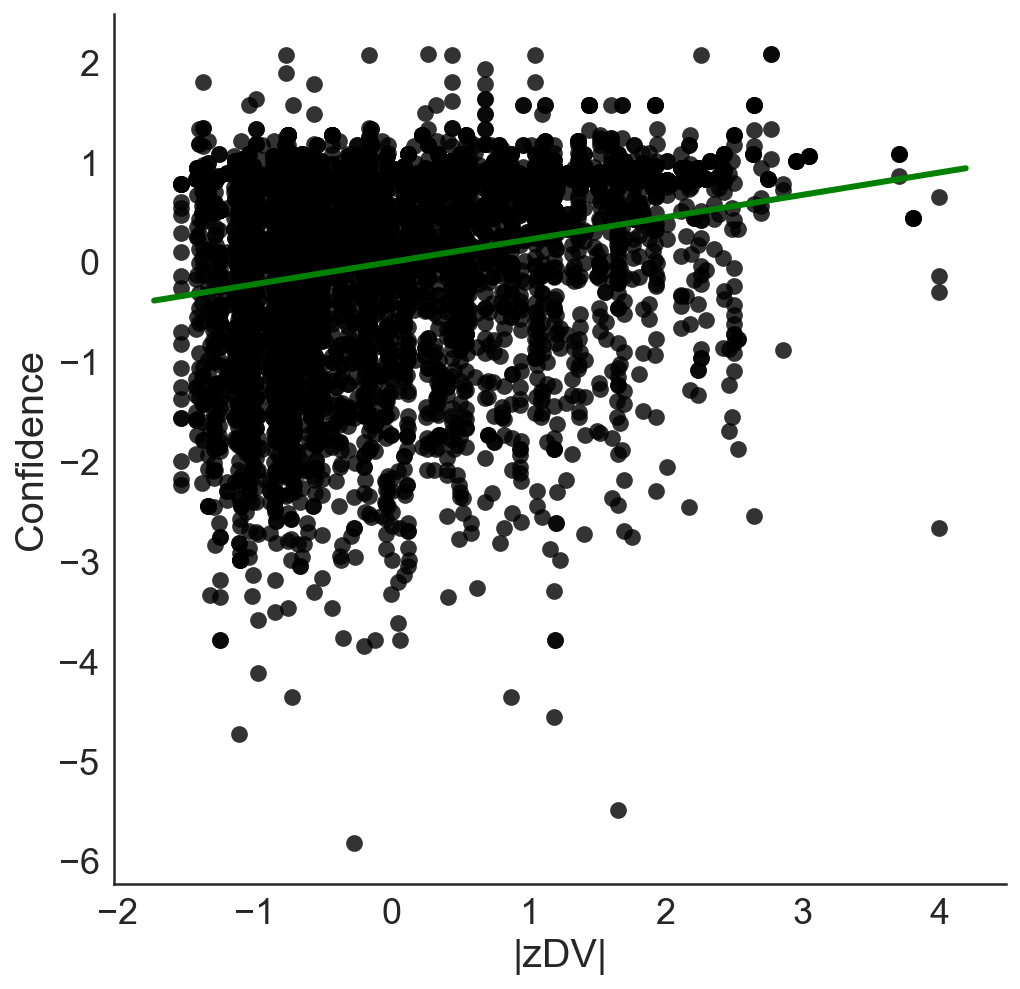

In [47]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_exp1[x_variable]
y=data_exp1[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Green', lw=3)
sns.despine()

results = pearsonr(data_exp1[x_variable], data_exp1[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

## Like Condition Only

In [48]:
#Select Condition 
data_expL = data_exp1.loc[data_exp1['BlockCond'] == 1] # 1 = Like, 2 = Dislike
len(data_expL)

2760

### Insert the variables to calculate the correlation

In [49]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.241 p =  0.0


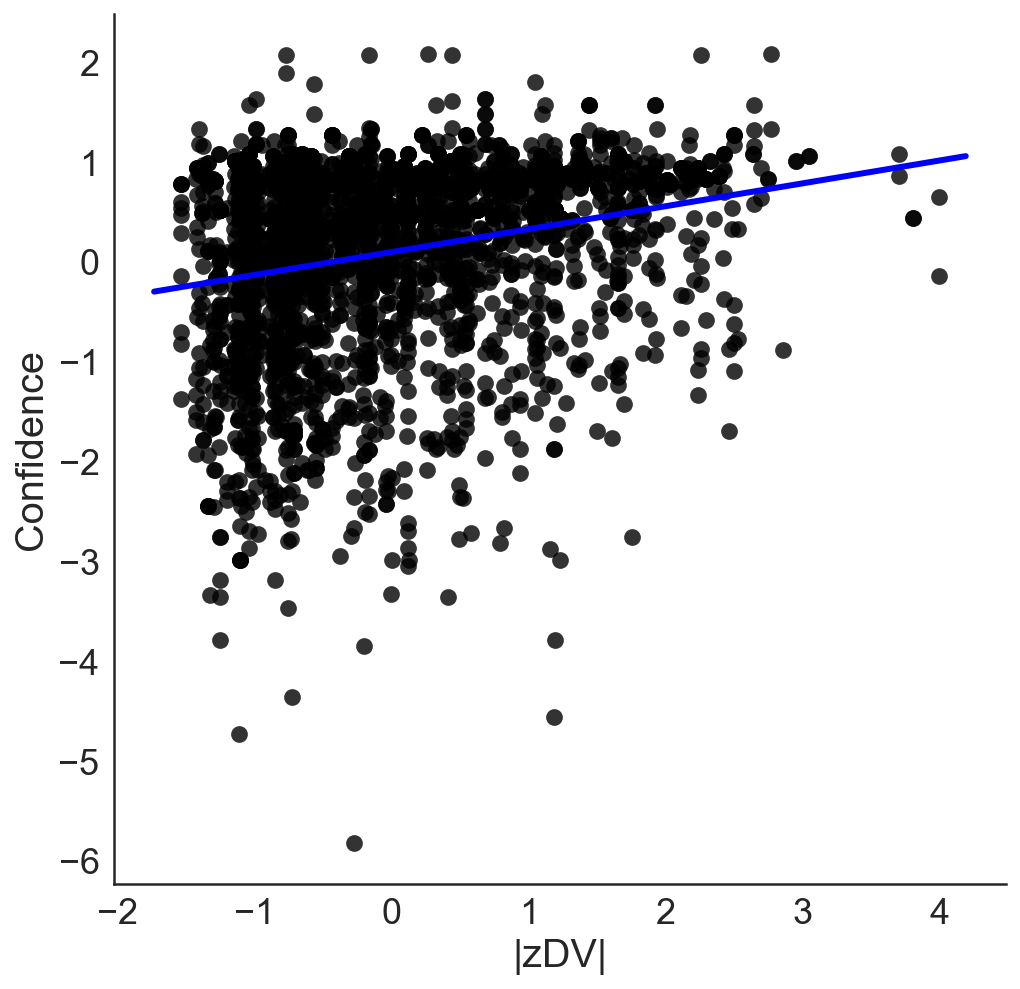

In [50]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_expL, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expL[x_variable]
y=data_expL[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Blue', lw=3)
sns.despine()

results = pearsonr(data_expL[x_variable], data_expL[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

## Dislike Condition Only

In [51]:
data_expD = data_exp1.loc[data_exp1['BlockCond'] == 2] # 1 = Like, 2 = Dislike

### Insert the variables to calculate the correlation

In [52]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.21 p =  0.0


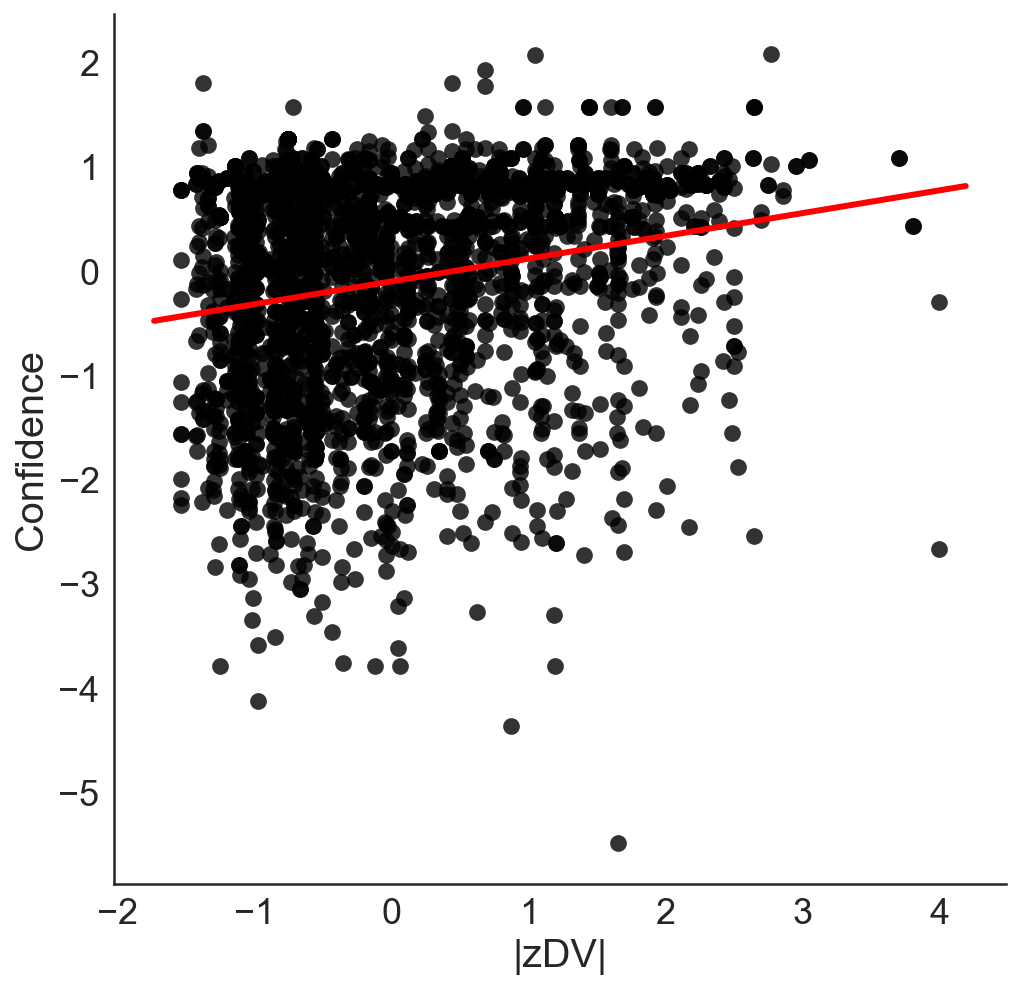

In [53]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_expD, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expD[x_variable]
y=data_expD[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Red', lw=3)
sns.despine()

results = pearsonr(data_expD[x_variable], data_expD[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

<a id='log'></a>
# Logistic Plots

### Difference in value (DV) is calculated as (Value_Right  - Value_Left)

## Like Condition

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


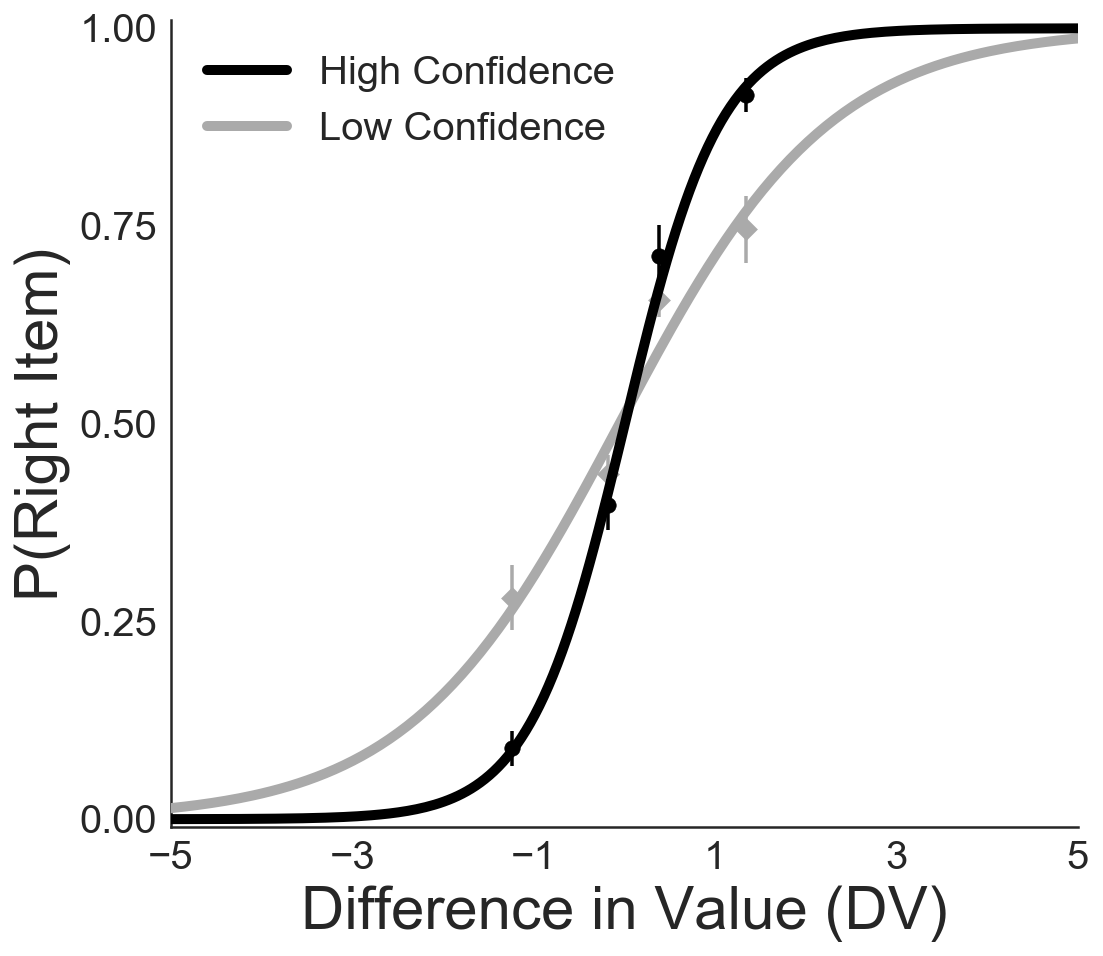

In [54]:
# Split by high/low conf
logisticplot_all('ConfSplit', 'High Confidence', 'Low Confidence', data=data_expL, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


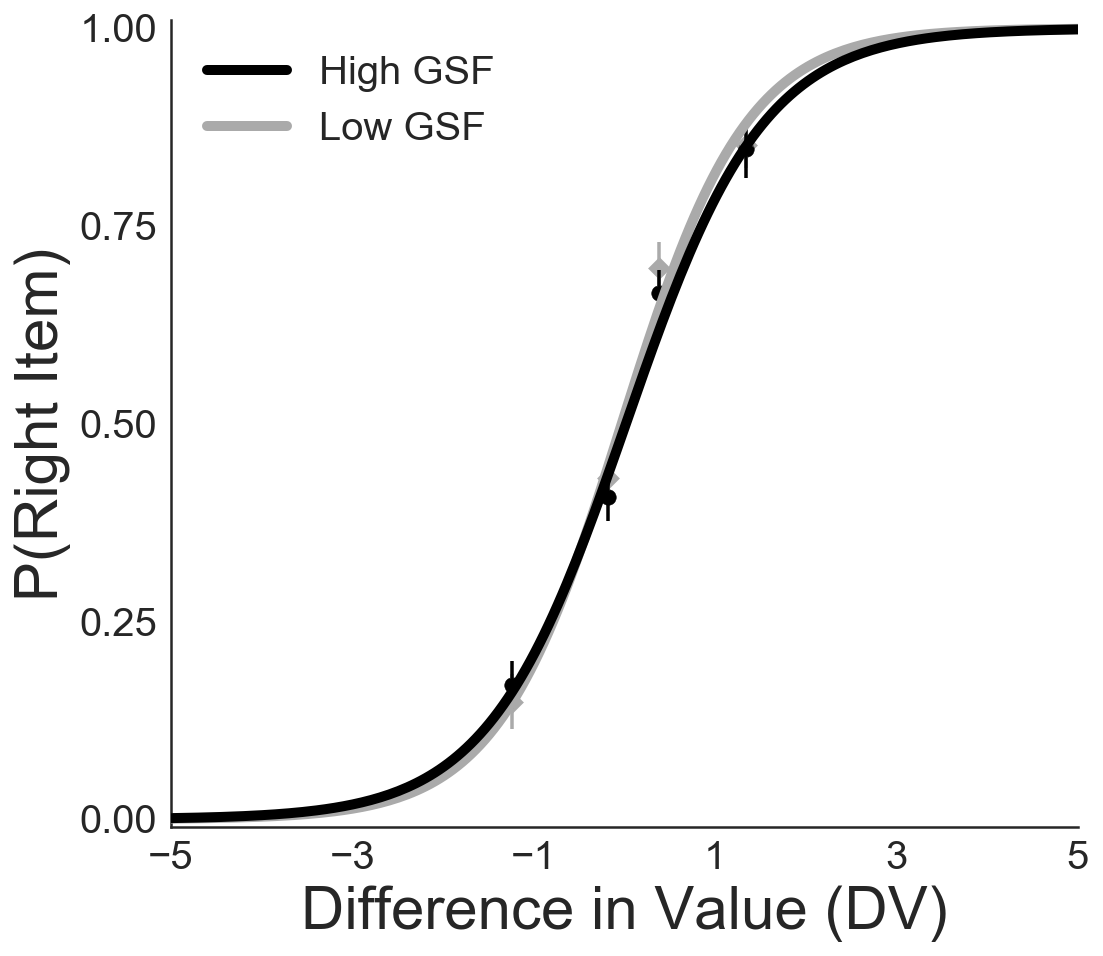

In [55]:
# Split by high/low gaze shift frequency
logisticplot_all('GSFMedSplit', 'High GSF', 'Low GSF', data=data_expL, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


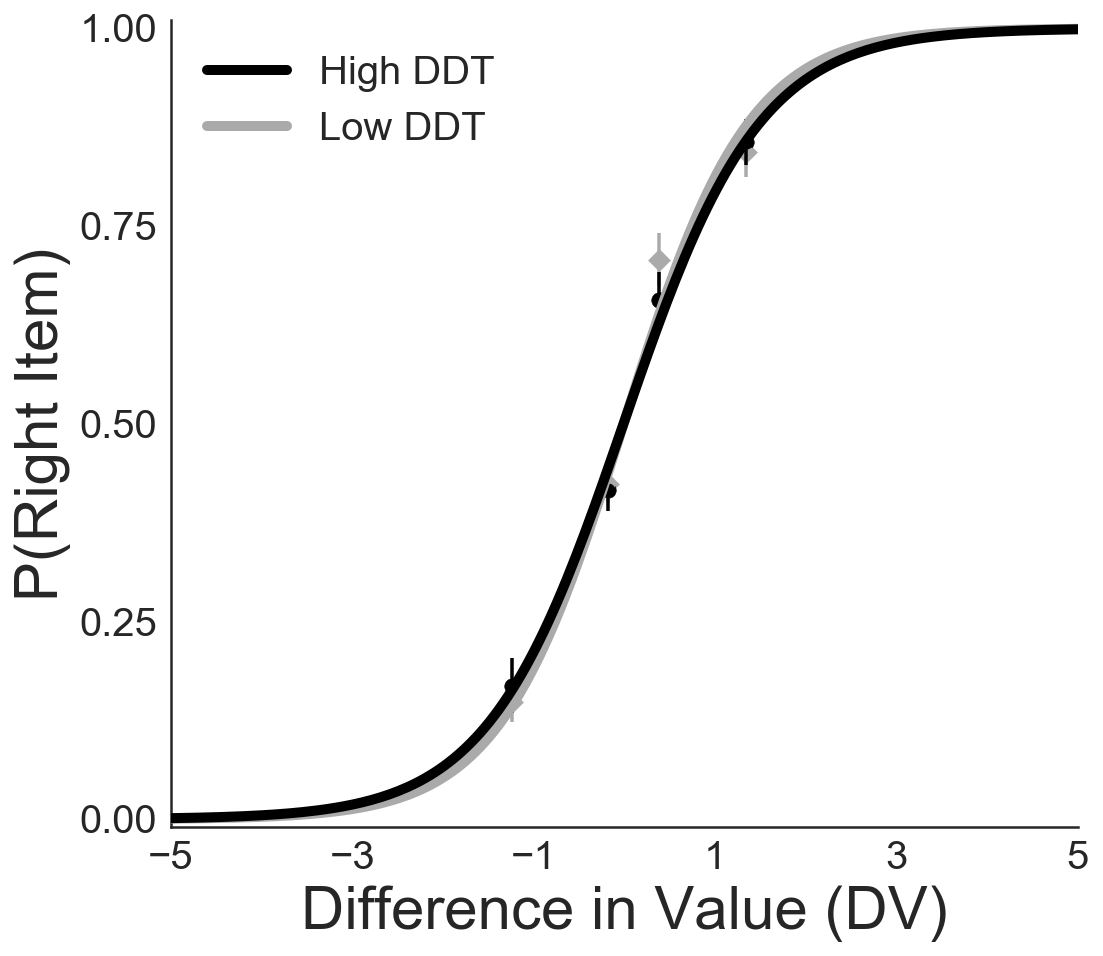

In [56]:
# Split by high/low dwelling time
logisticplot_all('DDTMedSplit', 'High DDT', 'Low DDT', data=data_expL, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


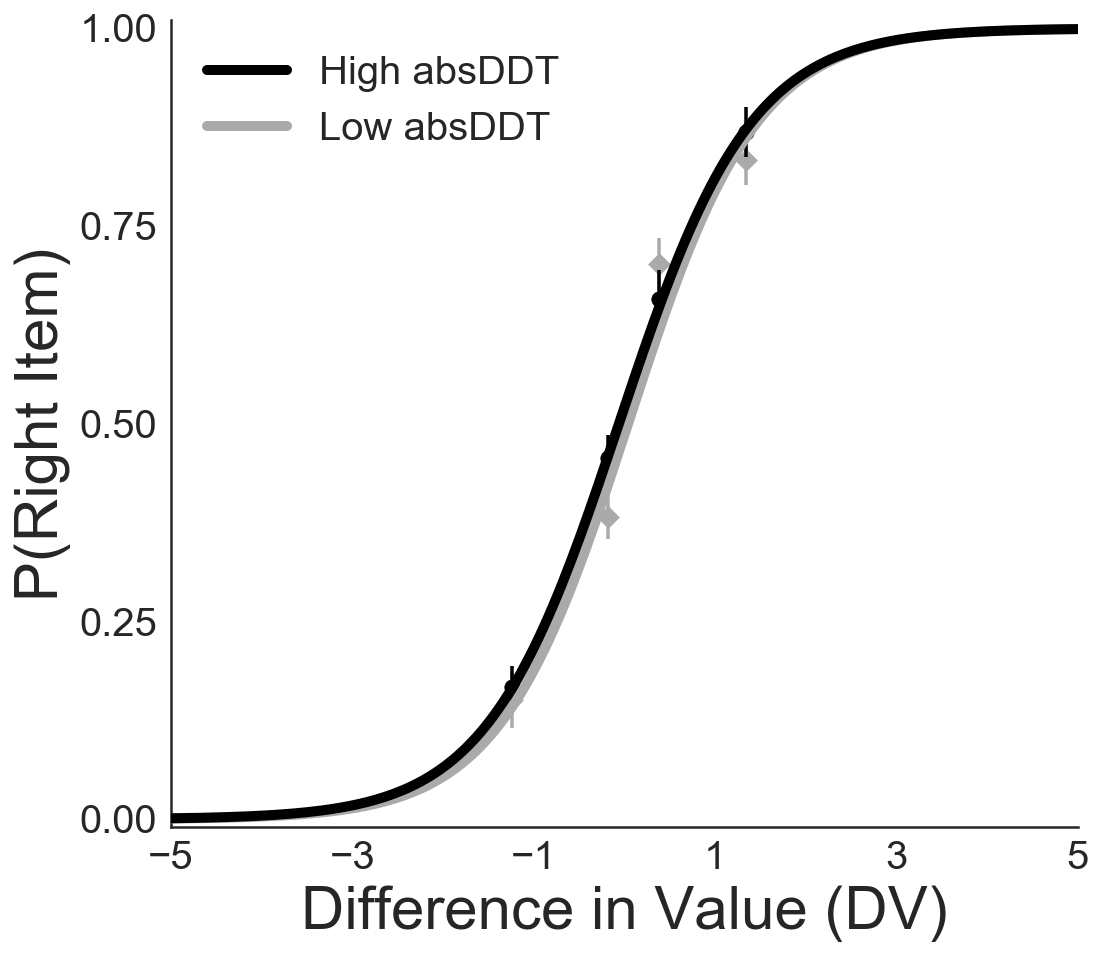

In [57]:
#absolute DDT
logisticplot_all('absDDTMedSplit', 'High absDDT', 'Low absDDT', data=data_expL
            , xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

## Dislike Condition

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


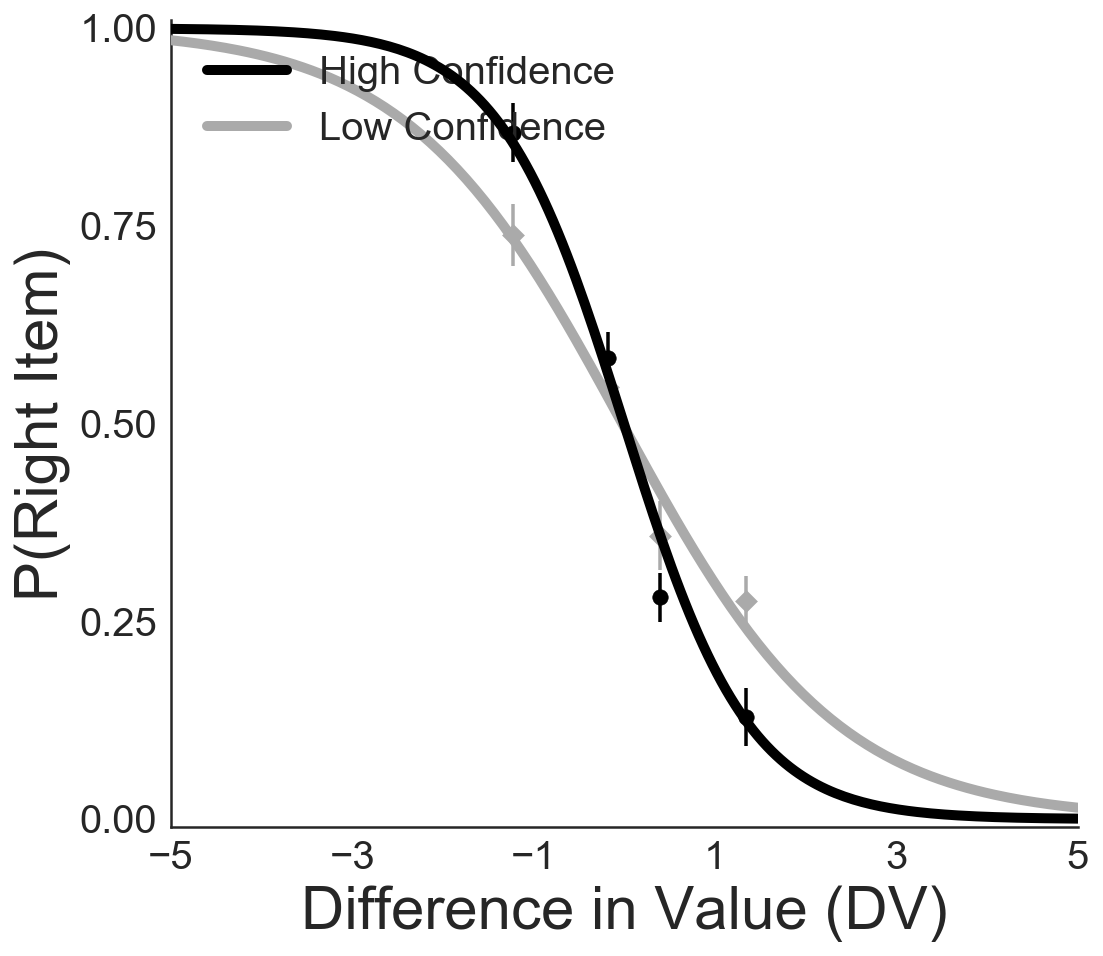

In [58]:
# Split by high/low conf
logisticplot_all('ConfSplit', 'High Confidence', 'Low Confidence', data=data_expD, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


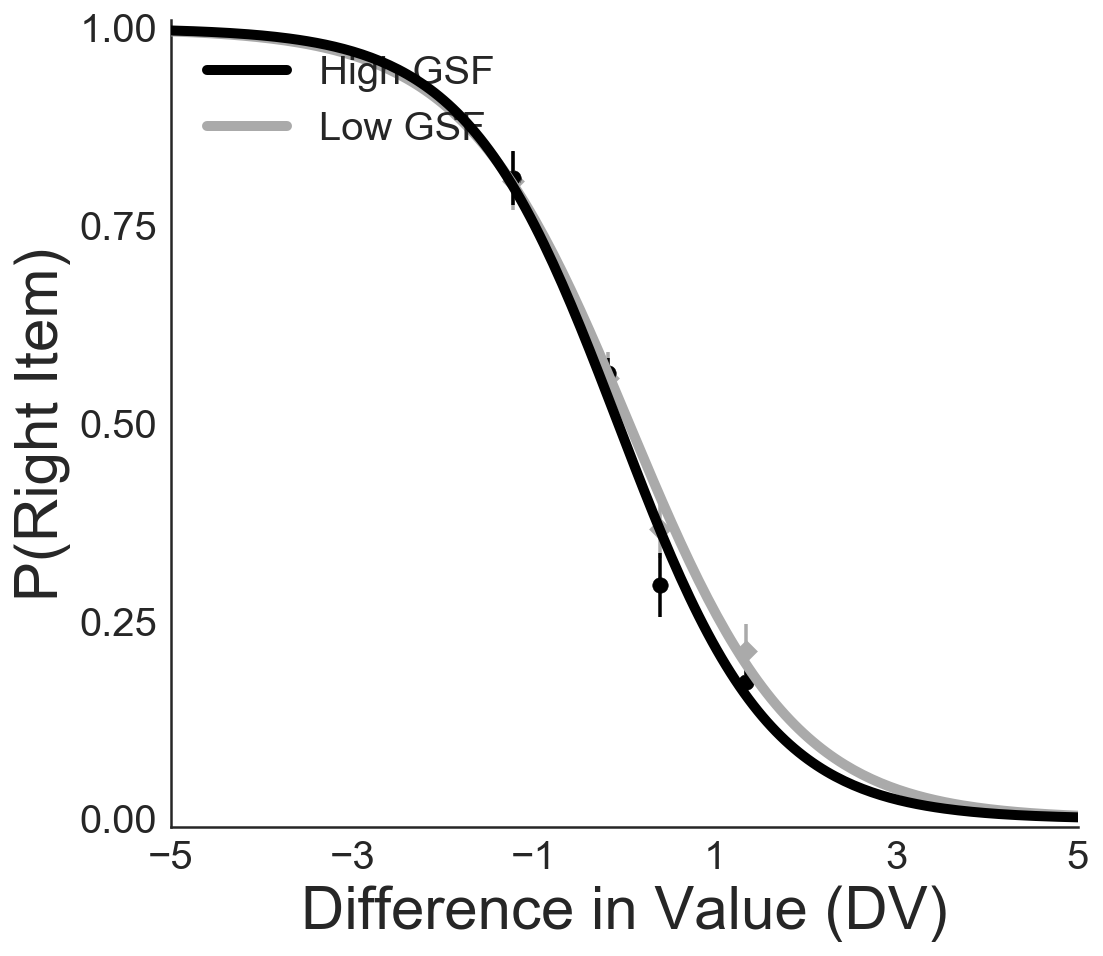

In [59]:
# Split by high/low gaze shift frequency
logisticplot_all('GSFMedSplit', 'High GSF', 'Low GSF', data=data_expD, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


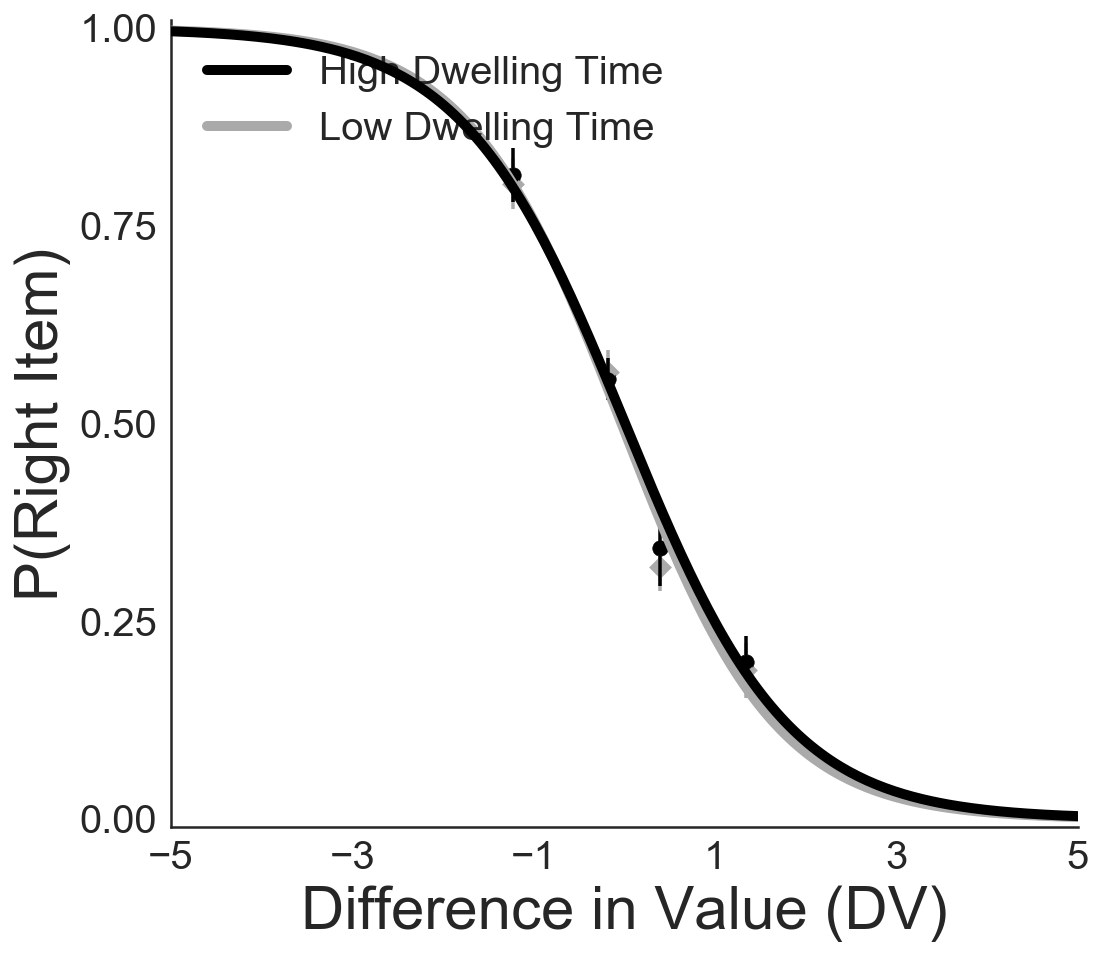

In [60]:
# Split by high/low dwelling time
logisticplot_all('DDTMedSplit', 'High Dwelling Time', 'Low Dwelling Time', data=data_expD, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

<a id='reg'></a>
# Regression Analysis

## Loading data in R

In [61]:
%R -i data_exp1
data_exp1

Part  TrialN  PairID                                L_Item  L_Value  \
0        1       1      14                116_boots_caramels.png     0.95   
1        1       2      44          102_propercorn_worcester.png     2.30   
2        1       3      51                       59_crunchie.png     1.70   
3        1       4      12               64_nestle_aero_mint.png     1.55   
4        1       5       4           44_walkers_french_fries.png     2.00   
5        1       6      39       50_nakd_rhubarb_and_custard.png     0.65   
6        1       7      59           54_milkyway_magic_stars.png     1.55   
7        1       8      16                116_boots_caramels.png     0.95   
8        1       9       1                  62_cadbury_wispa.png     1.55   
9        1      10      48           44_walkers_french_fries.png     2.00   
10       1      11      37                13_fruit_pastilles.png     1.10   
11       1      12       6     36_nature_valley_protein_bars.png     1.40   
12       1      13      35         41_jelly_babies_berry_mix.png     1.85   
13       1      14      45                       51_smarties.png     1.70   
14       1      15      58                       5_caramello.png     1.25   
15       1      16      41                   11_lindt_orange.png     2.00   
16       1      17      42                         63_kitkat.png     1.85   
17       1      18      52       42_dairy_milk_fruit_and_nut.png     1.55   
18       1      19      49            52_discos_salt_vinegar.png     1.70   
19       1      20      33                         26_yorkie.png     1.70   
20       1      21       7             30_starburst_original.png     1.10   
21       1      22      38                   56_marshmallows.png     0.95   
22       1      23      47                       51_smarties.png     1.70   
23       1      24      34                     19_pistachios.png     1.70   
24       1      25      15  57_food_doctor_mild_korma_crisps.png     1.25   
25       1      26       5                113_walkers_cheese.png     2.00   
26       1      27      46            112_lindt_extra_creamy.png     1.85   
27       1      28      50                         63_kitkat.png     1.85   
28       1      29      43                    103_nakd_berry.png     1.85   
29       1      30      11                     18_galaxy_bar.png     1.10   
...    ...     ...     ...                                   ...      ...   
5490    23     211      32                           24_twix.png     0.95   
5491    23     212       1                     31_beef_jerky.png     1.40   
5492    23     213      24                   56_marshmallows.png     1.40   
5493    23     214       8                 23_kp_grazing_mix.png     1.55   
5494    23     215      29     55_bassetts_licorice_allsorts.png     0.65   
5495    23     216      22                   11_lindt_orange.png     2.00   
5496    23     217       9     53_eat_natural_almond_apricot.png     1.10   
5497    23     218      17             115_shapers_blueberry.png     0.95   
5498    23     219      56            52_discos_salt_vinegar.png     0.95   
5499    23     220      27     36_nature_valley_protein_bars.png     0.65   
5500    23     221      34                113_walkers_cheese.png     0.95   
5501    23     222       4                    110_bombay_mix.png     1.10   
5502    23     223      33  57_food_doctor_mild_korma_crisps.png     0.95   
5503    23     224      60        111_propercorn_sweetnsalty.png     0.95   
5504    23     225      58     36_nature_valley_protein_bars.png     0.65   
5505    23     226      57            60_caramel_rice_crisps.png     0.95   
5506    23     227      21                      109_kp_roast.png     1.55   
5507    23     228      19                       59_crunchie.png     0.95   
5508    23     229      30                    48_mentos_mint.png     0.95   
5509    23     230      23       50_nakd_rhubarb_and_custard.png     1.10   
55

In [62]:
%%R
#Change Column name for better regression presentation
colnames(data_exp1)[which(names(data_exp1) == "zChoiceRT")] <- "zRT"
colnames(data_exp1)[which(names(data_exp1) == "ChoiceRT")] <- "RT"
colnames(data_exp1)[which(names(data_exp1) == "ztDDT")] <- "zDDT"
colnames(data_exp1)[which(names(data_exp1) == "ztGSF")] <- "zGSF"

In [63]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_exp1[ which(data_exp1$BlockCond=='1'), ]
data_exp1_DisLike <- data_exp1[ which(data_exp1$BlockCond=='2'), ]

## Comparing groups mean per condition 

[1] "T-test for RT across groups "

	Welch Two Sample t-test

data:  data_exp1_Like[["RT"]] and data_exp1_DisLike[["RT"]]
t = -6.3298, df = 5495.8, p-value = 2.649e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -370.8416 -195.4548
sample estimates:
mean of x mean of y 
 2588.470  2871.618 

[1] "T-test for CONFIDENCE across groups "

	Welch Two Sample t-test

data:  data_exp1_Like[["Conf"]] and data_exp1_DisLike[["Conf"]]
t = 7.4756, df = 5392.4, p-value = 8.916e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.868970 6.619436
sample estimates:
mean of x mean of y 
 78.76522  73.52101 



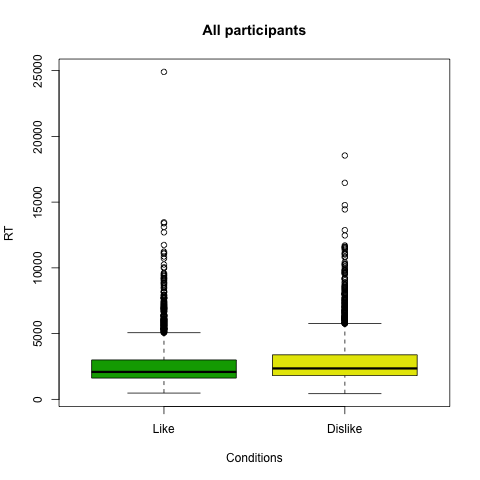

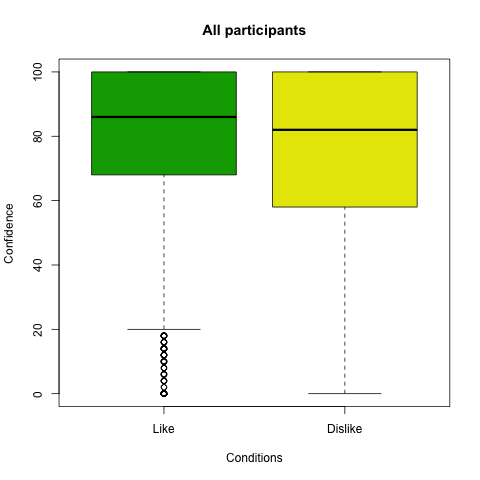

In [64]:
%%R
#Checking that RT and confidence levels are similar across conditions (like-dislike)
MeanLikeRT = mean(data_exp1_Like[["RT"]])
MeanDislikeRT = mean(data_exp1_DisLike[["RT"]])

MeanLikeConf = mean(data_exp1_Like[["Conf"]])
MeanDislikeConf = mean(data_exp1_DisLike[["Conf"]])

p_rt = t.test(data_exp1_Like[["RT"]],data_exp1_DisLike[["RT"]])
p_conf = t.test(data_exp1_Like[["Conf"]],data_exp1_DisLike[["Conf"]])

#Generate boxpot for Reaction time per condition
boxplot(data_exp1$RT ~ data_exp1$BlockCond , col=terrain.colors(4), names=c("Like","Dislike"))
title(main="All participants", 
   xlab="Conditions", ylab="RT")

#Generate boxpot for Confidence per condition
boxplot(data_exp1$Conf ~ data_exp1$BlockCond , col=terrain.colors(4), names=c("Like","Dislike"))
title(main="All participants", 
   xlab="Conditions", ylab="Confidence")

## Add data points
#mylevels<-levels(data_exp1$BlockCond)
#levelProportions<-summary(data_exp1$BlockCond)/nrow(data_exp1)
#for(i in 1:length(mylevels)){
#  thislevel<-mylevels[i]
#  thisvalues<-data_exp1[data_exp1$BlockCond==thislevel, "RT"]

#   # take the x-axis indices and add a jitter, proportional to the N in each level
#  myjitter<-jitter(rep(i, length(thisvalues)), amount=levelProportions[i]/2)
#  points(myjitter, thisvalues, pch=20, col=rgb(0,0,0,.2))  
#}

print("T-test for RT across groups ")
print(p_rt)

print("T-test for CONFIDENCE across groups ")
print( p_conf)

## Regressions per Condition (Like/Dislike)
### ChoiceITM~ BehavioralParams + DDT

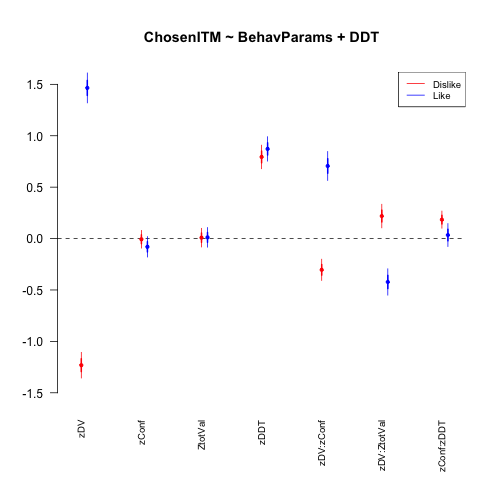

In [65]:
%%R
# Figure replicating Folke 2016.

logitModLike_FF2017 <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_exp1_Like, family=binomial(link="logit"))
logitModDislike_FF2017 <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_exp1_DisLike, family=binomial(link="logit"))

coefplot(logitModDislike_FF2017,intercept=FALSE,vertical = FALSE,  col.pts="red", mar = c(3,4,5,1) ,ylim=c(-1.5, 1.5) ,main="ChosenITM ~ BehavParams + DDT")
coefplot(logitModLike_FF2017, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1))
legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=0.8)

### Confidence ~ BehavParams + GSF

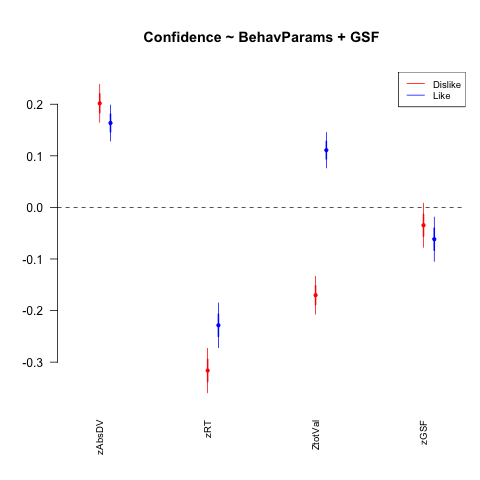

In [66]:
%%R
# Figure replicating Folke 2016. 

logitModLike_FF2017 <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF , data=data_exp1_Like)
logitModDislike_FF2017 <- glm(zConf ~ zAbsDV + zRT + ZtotVal + zGSF , data=data_exp1_DisLike)

#summary(logitMod_FF2017)
#summary(logitModLike_FF2017)
#summary(logitModUnlike_FF2017)

coefplot(logitModDislike_FF2017,intercept=FALSE, vertical = FALSE, col.pts="red", offset = 0.05, mar = c(3,4,5,1) ,main="Confidence ~ BehavParams + GSF")
coefplot(logitModLike_FF2017, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1),main="RegEstim")
legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=0.8)

# Generate regression plots for condition and individual participants 
## ChoiceITM~ BehavioralParams + DDT

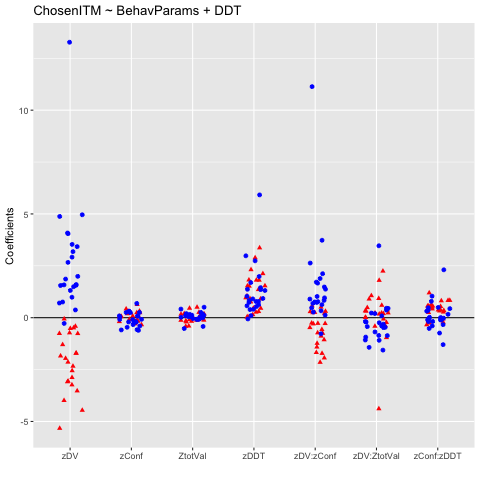

In [74]:
%%R
#Generate regression plots for individual participants 
#ChoiceITM~ BehavioralParams + DDT

#Run for all the participants

# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 7)
for (i in unique(data_exp1_Like[,"Part"])){
data_rgrs_subj  <- data_exp1_Like[ which(data_exp1_Like$Part==i), ]
rsults <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:8])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameLike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length(a)){
colnames(CoefsDataFrameLike)[j-1] <- a[j]
}
CoefsDataFrameLike

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 7)
for (i in unique(data_exp1_DisLike[,"Part"])){
data_rgrs_subj  <- data_exp1_DisLike[ which(data_exp1_DisLike$Part==i), ]
rsults <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:8])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameDislike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameDislike)[j-1] <- a[j]
}
CoefsDataFrameDislike

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameDislike),aes(x=variable, y=value), shape = 17, color='red', position = jitter) +
      geom_point(data = melt(CoefsDataFrameLike), aes(x=variable, y=value),color='blue', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("ChosenITM ~ BehavParams + DDT") + theme(legend.position="Top") 

#save as an image
ggsave("Output/Choice_Reg_Participant.tiff", units="in", width=6, height=4, dpi=300, compression = 'lzw')
plot2

### Different colors by participant

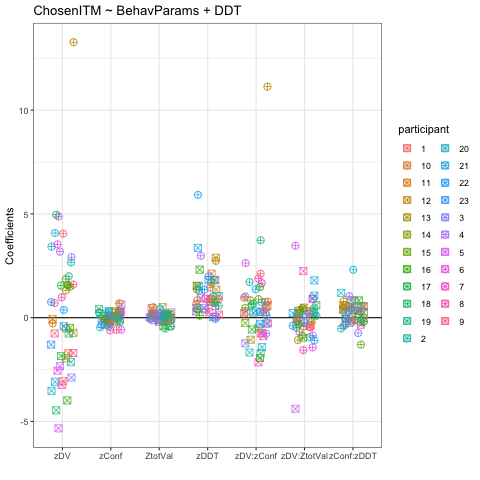

In [75]:
%%R
CoefsDataFrameLike <- melt(CoefsDataFrameLike)
CoefsDataFrameDislike <- melt(CoefsDataFrameDislike)

CoefsDataFrameLike$participant      <- as.character(rep(unique(data_exp1_Like[,"Part"]), length (a)-1))
CoefsDataFrameDislike$participant<- as.character(rep(unique(data_exp1_DisLike[,"Part"]), length (a)-1))

jitter <- position_jitter(width = 0.25)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = CoefsDataFrameDislike,aes(x=variable, y=value, colour =participant ), shape = 7,size = 3, position = jitter,show.legend = TRUE) +
      geom_point(data = CoefsDataFrameLike, aes(x=variable, y=value, colour = participant), shape = 10, position = jitter,size = 3,,show.legend = TRUE)  +
      labs(x = "", y = "Coefficients") + 
      ggtitle("ChosenITM ~ BehavParams + DDT")+
      theme_bw()
#save as an image
ggsave("Output/Choice_Reg_ParticipantColors.tiff", units="in", width=8, height=4, dpi=300, compression = 'lzw')

plot2

## Confidence ~ BehavParams + GSF

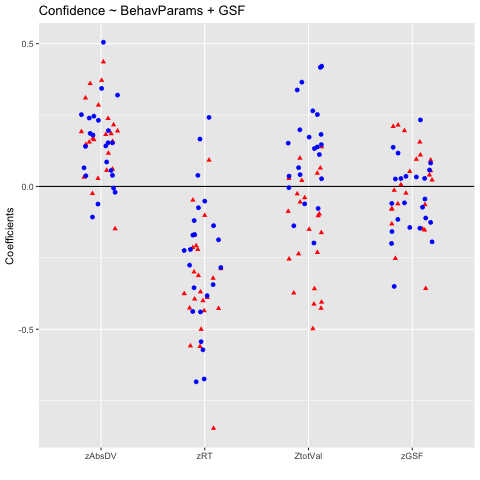

In [76]:
%%R

#Generate regression plots for individual participants 
# Confidence ~ BehavParams + GSF

#Run for all the participants

# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 4)
for (i in unique(data_exp1_Like[,"Part"])){
data_rgrs_subj  <- data_exp1_Like[ which(data_exp1_Like$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:5])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameLike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameLike)[j-1] <- a[j]
}
CoefsDataFrameLike

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 4)
for (i in unique(data_exp1_DisLike[,"Part"])){
data_rgrs_subj  <- data_exp1_DisLike[ which(data_exp1_DisLike$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:5])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameDislike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameDislike)[j-1] <- a[j]
}
CoefsDataFrameDislike

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameDislike),aes(x=variable, y=value), shape = 17, color='red', position = jitter) +
      geom_point(data = melt(CoefsDataFrameLike), aes(x=variable, y=value),color='blue', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Confidence ~ BehavParams + GSF") + theme(legend.position="Top") 
      
ggsave("Output/Confidence_Reg_Participant.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')

plot2


### Different colors by participant

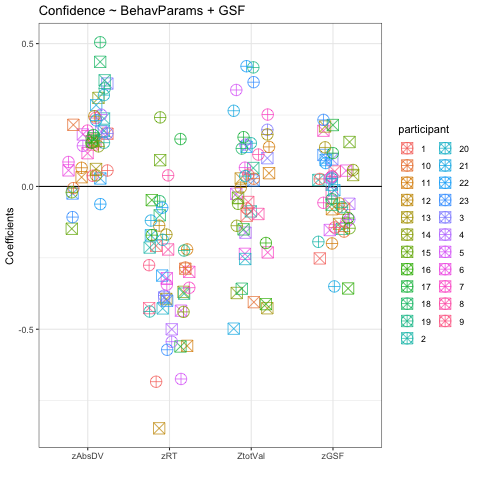

In [77]:
%%R
CoefsDataFrameLike <- melt(CoefsDataFrameLike)
CoefsDataFrameDislike <- melt(CoefsDataFrameDislike)

CoefsDataFrameLike$participant      <- as.character(rep(unique(data_exp1_Like[,"Part"]), length (a)-1))
CoefsDataFrameDislike$participant<- as.character(rep(unique(data_exp1_DisLike[,"Part"]), length (a)-1))

jitter <- position_jitter(width = 0.25)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = CoefsDataFrameDislike,aes(x=variable, y=value, colour =participant ), shape = 7,size = 5, position = jitter,show.legend = TRUE) +
      geom_point(data = CoefsDataFrameLike, aes(x=variable, y=value, colour = participant), shape = 10, position = jitter,size = 5,,show.legend = TRUE)  +
      labs(x = "", y = "Coefficients") + 
      ggtitle("Confidence ~ BehavParams + GSF")+
      theme_bw()
 
ggsave("Output/Confidence_Reg_ParticipantColors.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')

plot2

In [71]:
#--------------------------------------------------------------------------------

In [72]:
#END 